# Prediction #


In [160]:
import pandas as pd
import numpy as np
from sklearn import feature_selection
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn import datasets, ensemble
from sklearn import metrics
from sklearn.metrics import mean_squared_error,roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression,LinearRegression, PoissonRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, IsolationForest
import pickle
import seaborn as sns

In [161]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# we will see how this compares to betting odds auc

#FIX MATCHWEEK
train['Matchweek'] = train['Matchweek'].apply(lambda x: int(x.split()[-1]))
test['Matchweek'] = test['Matchweek'].apply(lambda x: int(x.split()[-1]))


In [162]:
print(train.columns)

Index(['Unnamed: 0', 'HomePlayer_Overall_max', 'HomePlayer_Overall_min', 'HomePlayer_Overall_sd', 'HomePlayer_Overall_mean', 'HomePlayer_Overall_mean_ln', 'HomePlayer_Overall_mean_sqrt', 'HomePlayer_3rd_best', 'HomePlayer_3rd_worst', 'HomePlayer_bench_Overall_mean', 'HomePlayer_bench_Overall_max', 'HomePlayer_bench_Overall_min', 'HomePlayer_bench_Overall_sd', 'AwayPlayer_Overall_max', 'AwayPlayer_Overall_min', 'AwayPlayer_Overall_sd', 'AwayPlayer_Overall_mean', 'AwayPlayer_Overall_mean_ln', 'AwayPlayer_Overall_mean_sqrt', 'AwayPlayer_3rd_best', 'AwayPlayer_3rd_worst', 'AwayPlayer_bench_Overall_mean', 'AwayPlayer_bench_Overall_max', 'AwayPlayer_bench_Overall_min', 'AwayPlayer_bench_Overall_sd', 'home_team_name', 'away_team_name', 'home_score', 'away_score', 'home_GD_prior', 'home_Points_prior', 'home_GD_form', 'home_Points_form', 'away_GD_prior', 'away_Points_prior', 'away_GD_form', 'away_Points_form', 'Matchweek', 'B365A', 'B365D', 'B365H'], dtype='object')


In [163]:

train.drop(['home_GD_prior', 'home_Points_prior', 'away_GD_prior', 'away_Points_prior',  'AwayPlayer_3rd_best', 'AwayPlayer_3rd_worst',
            'HomePlayer_3rd_best', 'HomePlayer_3rd_worst',  'Matchweek', 'HomePlayer_Overall_mean',
            'HomePlayer_Overall_mean_sqrt','AwayPlayer_Overall_mean',
            'AwayPlayer_Overall_mean_sqrt',
            'HomePlayer_Overall_min', 'HomePlayer_Overall_max',
            'AwayPlayer_Overall_min','AwayPlayer_Overall_max'], inplace=True, axis=1)
test.drop(['home_GD_prior', 'home_Points_prior', 'away_GD_prior', 'away_Points_prior',  'AwayPlayer_3rd_best', 'AwayPlayer_3rd_worst',
            'HomePlayer_3rd_best', 'HomePlayer_3rd_worst',  'Matchweek', 'HomePlayer_Overall_mean',
            'HomePlayer_Overall_mean_sqrt','AwayPlayer_Overall_mean',
            'AwayPlayer_Overall_mean_sqrt',
            'HomePlayer_Overall_min', 'HomePlayer_Overall_max',
            'AwayPlayer_Overall_min','AwayPlayer_Overall_max'], inplace=True, axis=1)

In [164]:
train.drop(['Unnamed: 0'], axis=1, inplace=True)
test.drop(['Unnamed: 0'], axis=1, inplace=True)


In [165]:
# cols_to_keep = ['home_score','away_score','home_team_name', 'away_team_name',
#                 'HomePlayer_Overall_mean',  'AwayPlayer_Overall_mean', 
#                 'HomePlayer_Overall_sd',
#                 'AwayPlayer_Overall_sd','HomePlayer_Overall_mean_ln', 
#                 'AwayPlayer_Overall_mean_ln', 'HomePlayer_Overall_max', 'HomePlayer_Overall_min',
#                 'AwayPlayer_Overall_max', 'AwayPlayer_Overall_min',
#                 'home_GD_form_pw', 'away_GD_form_pw',
#                 'home_Points_form_pw', 'away_Points_form_pw',
#                  'home_points_to_championship',
#                 'home_points_to_ucl','home_points_to_rel','away_points_to_championship',
#                 'away_points_to_ucl','away_points_to_rel']
# train = train[cols_to_keep]
# test = test[cols_to_keep]

In [166]:
# train["Home_min_max"] = train['HomePlayer_Overall_max'] * train['HomePlayer_Overall_min']
# train['Away_min_max'] = train['AwayPlayer_Overall_max'] * train['AwayPlayer_Overall_min']

# test["Home_min_max"] = test['HomePlayer_Overall_max'] * test['HomePlayer_Overall_min']
# test['Away_min_max'] = test['AwayPlayer_Overall_max'] * test['AwayPlayer_Overall_min']

for col in train.columns:
    if 'bench' in col or 'points_to' in col:
        train.drop(col, axis=1, inplace=True)
        test.drop(col, axis=1, inplace=True)

In [167]:
# train['OvO'] = train['HomePlayer_Overall_mean'] - train['AwayPlayer_Overall_mean']
# train['OvO_sqrt'] = train['HomePlayer_Overall_mean_sqrt'] - train['AwayPlayer_Overall_mean_sqrt']
# train['OvO_ln'] = train['HomePlayer_Overall_mean_sqrt'] - train['AwayPlayer_Overall_mean_sqrt']

# test['OvO'] = test['HomePlayer_Overall_mean'] - test['AwayPlayer_Overall_mean']
# test['OvO_sqrt'] = test['HomePlayer_Overall_mean_sqrt'] - test['AwayPlayer_Overall_mean_sqrt']
# test['OvO_ln'] = test['HomePlayer_Overall_mean_sqrt'] - test['AwayPlayer_Overall_mean_sqrt']

# train.drop(['AwayPlayer_Overall_mean', 'HomePlayer_Overall_mean',
#             'AwayPlayer_Overall_mean_sqrt', 'HomePlayer_Overall_mean_sqrt',
#             'AwayPlayer_Overall_mean_ln', 'HomePlayer_Overall_mean_ln'], axis=1, inplace=True)
# test.drop(['AwayPlayer_Overall_mean', 'HomePlayer_Overall_mean',
#             'AwayPlayer_Overall_mean_sqrt', 'HomePlayer_Overall_mean_sqrt',
#             'AwayPlayer_Overall_mean_ln', 'HomePlayer_Overall_mean_ln'], axis=1, inplace=True)

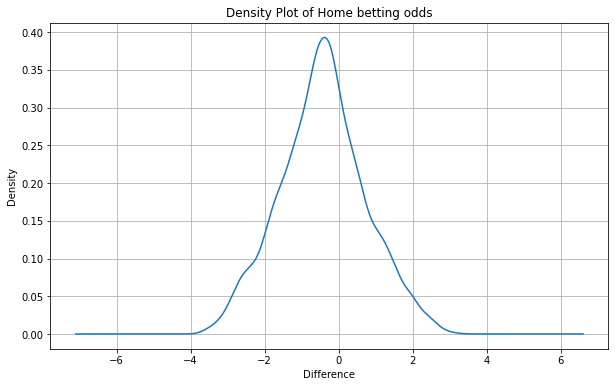

In [168]:
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
train['bo_diff'] = np.log(train['B365H'] / train['B365A'])
test['bo_diff'] = np.log(test['B365H'] / train['B365A'])

train['bo_diff'].plot(kind='density')
plt.title('Density Plot of Home betting odds')
plt.xlabel('Difference')
plt.ylabel('Density')
plt.grid(True)
plt.show()



In [169]:
# ### Dealing with outliers

# # Create a new column 'difference' which is the difference between 'HomePlayer_Overall_mean' and 'away'
# train['difference'] = train['HomePlayer_Overall_mean'] - train['AwayPlayer_Overall_mean']
# test['difference'] = test['HomePlayer_Overall_mean'] - test['AwayPlayer_Overall_mean']

# # Plot the density plot for the difference
# plt.figure(figsize=(10, 6))  # Adjust figure size if needed
# train['difference'].plot(kind='density')
# plt.title('Density Plot of Difference between HomePlayer_Overall_mean and away')
# plt.xlabel('Difference')
# plt.ylabel('Density')
# plt.grid(True)
# plt.show()

In [170]:

# # Calculate the percentile values
# lower_percentile = train['difference'].quantile(0.025)
# upper_percentile = train['difference'].quantile(0.975)

# # Filter the data to remove bottom 2.5% and top 2.5%
# filtered_data = train[(train['difference'] >= lower_percentile) & (train['difference'] <= upper_percentile)]

# # Calculate the percentile values
# lower_percentile = train['bo_diff'].quantile(0.025)
# upper_percentile = train['bo_diff'].quantile(0.975)

# # Filter the data to remove bottom 2.5% and top 2.5%
# filtered_data = train[(train['bo_diff'] >= lower_percentile) & (train['bo_diff'] <= upper_percentile)]

# train.drop(['difference', 'bo_diff'], axis=1, inplace=True)

In [171]:
train.drop(['bo_diff'], axis=1, inplace=True)

In [172]:
train_back_up = train.copy()
test_back_up = test.copy()

In [173]:
#fixing the order of columns
test = test[train.columns]

In [174]:
print(set(list(test['home_team_name'])+list( train['home_team_name'])))

{'Bologna', 'Werder Bremen', 'RB Leipzig', 'Chelsea', 'Villarreal', 'Dortmund', 'Hull City', 'La Coruña', 'Real Madrid', 'Monza', 'Cardiff City', 'Fiorentina', 'Watford', 'Düsseldorf', 'Betis', 'Lazio', 'Aston Villa', 'Newcastle United', 'Girona', 'Sampdoria', 'Bochum', 'Eibar', 'Athletic Club', 'Wolverhampton Wanderers', 'Chievo', 'Sheffield United', 'Burnley', 'Augsburg', 'Köln', 'Genoa', 'Southampton', 'Almería', 'Sporting Gijón', 'Pescara', 'Brentford', 'Hellas Verona', 'Venezia', 'Leeds United', 'Atlético Madrid', 'Crotone', 'Getafe', 'Udinese', 'Napoli', 'Gladbach', 'Levante', 'Alavés', 'Osasuna', 'Elche', 'Mainz 05', 'AFC Bournemouth', 'Valencia', 'West Bromwich Albion', 'Union Berlin', 'Las Palmas', 'Middlesbrough', 'Milan', 'Juventus', 'Rayo Vallecano', 'Hannover 96', 'Manchester United', 'Espanyol', 'Nürnberg', 'West Ham United', 'Córdoba', 'Cagliari', 'Hamburger SV', 'SPAL', 'Celta Vigo', 'Barcelona', 'Leicester City', 'Sassuolo', 'Mallorca', 'Cremonese', 'Darmstadt 98', 'Su

In [175]:
# # Initialize the OneHotEncoder with handle_unknown='ignore'

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# One-hot encode 'home_team_name'
encoded = encoder.fit_transform(train[['home_team_name', 'away_team_name']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['home_team_name', 'away_team_name']))
encoded_test = encoder.transform(test[['home_team_name', 'away_team_name']])
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(['home_team_name', 'away_team_name']))
with open('encoder', 'wb') as f:
    pickle.dump(encoder, f)
# Concatenate the encoded columns with the original DataFrame
# train = pd.concat([encoded_df, train], axis=1)
# test = pd.concat([encoded_test_df, test], axis=1)

train.drop(['home_team_name', 'away_team_name'], axis=1, inplace=True)
test.drop(['home_team_name', 'away_team_name'], axis=1, inplace=True)

test = test[train.columns]


In [176]:
# Display rows with NA values in test DataFrame
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
train[train.isna().any(axis=1)]



,HomePlayer_Overall_sd,HomePlayer_Overall_mean_ln,AwayPlayer_Overall_sd,AwayPlayer_Overall_mean_ln,home_score,away_score,home_GD_form,home_Points_form,away_GD_form,away_Points_form,B365A,B365D,B365H
9091,2.522625,4.287418,2.292280,4.308536,3,2,-4.0,0.0,-4.0,3.0,NaN,NaN,NaN
9093,5.400337,4.228682,6.603030,4.286525,0,0,3.0,6.0,-4.0,3.0,NaN,NaN,NaN
10705,3.854160,4.311381,2.508168,4.344492,4,0,1.0,8.0,0.0,8.0,NaN,NaN,NaN


In [177]:
test.dropna(inplace=True)
train.dropna(inplace=True)

#print for sanity check

print(test.shape)
print(train.shape)

(1447, 13)
(11565, 13)


In [178]:
betting_data_test = test[['B365A', 'B365D', 'B365H']]

betting_data_test.drop('B365D', axis=1,inplace=True)
betting_data_train = train[['B365A', 'B365D', 'B365H']]

betting_data_train.drop('B365D', axis=1,inplace=True)

<ipython-input-178-370b01c7c6e7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_data_test.drop('B365D', axis=1,inplace=True)
<ipython-input-178-370b01c7c6e7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_data_train.drop('B365D', axis=1,inplace=True)


In [179]:
train.head()

,HomePlayer_Overall_sd,HomePlayer_Overall_mean_ln,AwayPlayer_Overall_sd,AwayPlayer_Overall_mean_ln,home_score,away_score,home_GD_form,home_Points_form,away_GD_form,away_Points_form,B365A,B365D,B365H
0,2.873072,4.298440,1.489356,4.372733,1,0,0.0,0.0,0.0,0.0,2.45,3.3,2.80
1,4.649536,4.242528,1.662419,4.287729,2,1,0.0,0.0,0.0,0.0,4.20,3.2,1.95
2,2.659460,4.349149,3.074824,4.347789,1,1,0.0,0.0,0.0,0.0,3.50,3.5,2.05
3,2.240130,4.266061,3.266914,4.297012,1,1,0.0,0.0,0.0,0.0,2.70,3.3,2.55
4,1.483240,4.262483,3.828126,4.321106,1,0,0.0,0.0,0.0,0.0,2.20,3.4,3.25


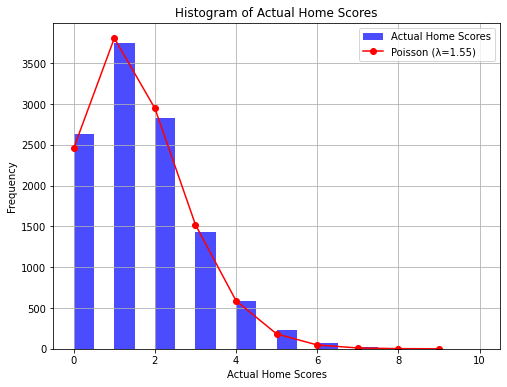

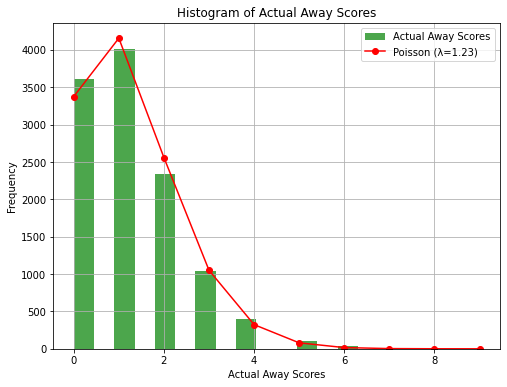

In [180]:
from scipy.stats import poisson

# Plot histogram for actual home scores
plt.figure(figsize=(8, 6))
plt.hist(train['home_score'], bins=20, color='blue', alpha=0.7, label='Actual Home Scores', density=False)
plt.xlabel('Actual Home Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Actual Home Scores')

# Calculate mean for home scores
mean_home_score = np.mean(train['home_score'])

# Generate Poisson distribution for home scores
x_home = np.arange(0, 10)
poisson_home = poisson.pmf(x_home, mean_home_score) * len(train['home_score'])
plt.plot(x_home, poisson_home, '-o', color='red', label='Poisson (λ={:.2f})'.format(mean_home_score))

plt.legend()
plt.grid(True)
plt.show()

# Plot histogram for actual away scores
plt.figure(figsize=(8, 6))
plt.hist(train['away_score'], bins=20, color='green', alpha=0.7, label='Actual Away Scores', density=False)
plt.xlabel('Actual Away Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Actual Away Scores')

# Calculate mean for away scores
mean_away_score = np.mean(train['away_score'])

# Generate Poisson distribution for away scores
x_away = np.arange(0, 10)
poisson_away = poisson.pmf(x_away, mean_away_score) * len(train['away_score'])
plt.plot(x_away, poisson_away, '-o', color='red', label='Poisson (λ={:.2f})'.format(mean_away_score))

plt.legend()
plt.grid(True)
plt.show()

In [181]:


train['GD'] = train['home_score'] - train['away_score']
test['GD'] = test['home_score'] - test['away_score']
#try later with both poisson and different regressions
ytrain_home = train['home_score']
ytrain_away = train['away_score']

ytest_home = test['home_score']
ytest_away = test['away_score']
# Dropping the columns


train.drop(['home_score', 'away_score'], axis=1, inplace=True)
test.drop(['home_score', 'away_score'], axis=1, inplace=True)


train.loc[train['GD'] > 0, 'label'] = 1
test.loc[test['GD'] > 0, 'label'] = 1


train.loc[train['GD'] <= 0, 'label'] = 0

test.loc[test['GD'] <= 0, 'label'] = 0


# Saving the gd as y_reg (y regression)

y_train_reg = train['GD']
y_test_reg = test['GD']

y_train = train['label']
y_test = test['label']




train.drop(['GD', 'label'], axis=1, inplace=True)
test.drop(['GD', 'label'], axis=1, inplace=True)


In [182]:
def get_versus(df, attributes, statistics):
    versus_df = pd.DataFrame()
    for att in attributes:
        for stat in statistics:
            versus_df[att+'_'+att+"__"+stat] = df['HomePlayer_'+att+'_'+stat] - df['AwayPlayer_'+att+'_'+stat]
    return versus_df

In [183]:
train.dropna(axis=0).shape

(11565, 11)

In [184]:
train.shape

(11565, 11)

In [185]:
train.head()

,HomePlayer_Overall_sd,HomePlayer_Overall_mean_ln,AwayPlayer_Overall_sd,AwayPlayer_Overall_mean_ln,home_GD_form,home_Points_form,away_GD_form,away_Points_form,B365A,B365D,B365H
0,2.873072,4.298440,1.489356,4.372733,0.0,0.0,0.0,0.0,2.45,3.3,2.80
1,4.649536,4.242528,1.662419,4.287729,0.0,0.0,0.0,0.0,4.20,3.2,1.95
2,2.659460,4.349149,3.074824,4.347789,0.0,0.0,0.0,0.0,3.50,3.5,2.05
3,2.240130,4.266061,3.266914,4.297012,0.0,0.0,0.0,0.0,2.70,3.3,2.55
4,1.483240,4.262483,3.828126,4.321106,0.0,0.0,0.0,0.0,2.20,3.4,3.25


In [186]:
to_log = ['Overall', 'Height', 'Weight']
'''
for col in train.columns:
    for t in to_log:
        if t in col:
            train[col] = np.log2(train[col])
            test[col] = np.log2(test[col])
'''
#versus_train = get_versus(train, to_log, ['mean','min','max','sd'])
#versus_test = get_versus(test, to_log, ['mean','min','max','sd'])


'\nfor col in train.columns:\n    for t in to_log:\n        if t in col:\n            train[col] = np.log2(train[col])\n            test[col] = np.log2(test[col])\n'

In [187]:
for col in train.columns:
    if col not in test.columns:
        print(col)
        print(test.columns)

In [188]:
train.to_csv('X_train.csv')
y_train.to_csv("Y_train.csv")
test.to_csv('X_test.csv')
y_test.to_csv("Y_test.csv")


In [189]:

# Standardize the data for numeric columns
scaler = StandardScaler()

train_scaled = scaler.fit_transform(train)
train_scaled = pd.DataFrame(train_scaled, columns=train.columns)

test_scaled = scaler.transform(test)
test_scaled = pd.DataFrame(test_scaled, columns=test.columns)


Text(0, 0.5, 'Density')

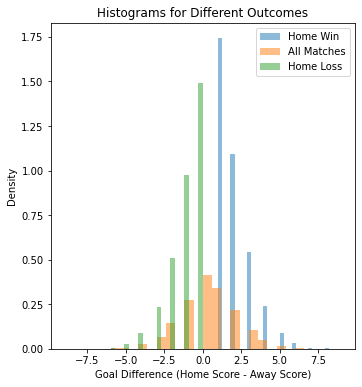

In [190]:

# Separate the data based on labels
home_win_data = y_train_reg[y_train == 1]
home_loss = y_train_reg[y_train == 0]

# Create histograms
plt.figure(figsize=(12, 6))

# Plot histograms
plt.subplot(1, 2, 1)
plt.hist(home_win_data, bins=30, alpha=0.5, label='Home Win', density=True)
plt.hist(y_train_reg, bins=30, alpha=0.5, label='All Matches', density=True)
plt.hist(home_loss, bins=30, alpha=0.5, label='Home Loss', density=True)
plt.legend()
plt.title('Histograms for Different Outcomes')
plt.xlabel('Goal Difference (Home Score - Away Score)')
plt.ylabel('Density')



In [191]:

from scipy.stats import norm, skellam

def bet_thresh(predict_proba_output, labels, earning_matrix, earning_odds, initial_dollar=1, extra_title='', threshold=0):
    # Find the index of the maximum predicted probability for each data point
    predicted_labels = np.argmax(predict_proba_output, axis=1)
    predicted_bo = np.argmax(earning_odds, axis=1)
    predicted_bet = []
    outcome_bet = []
    # Initialize earnings
    earnings = []
    bo_earnings = []
    
    # Iterate through each data point for regular betting
    for i in range(len(predicted_labels)):
        if predict_proba_output[i, predicted_labels[i]] > threshold:
            predicted_bet.append(predicted_labels[i])
            outcome_bet.append(labels[i])
            if predicted_labels[i] == labels[i]:
                earnings.append(initial_dollar * (earning_matrix.at[i, labels[i]] - 1))
            else:
                earnings.append(-initial_dollar)  # If the prediction is incorrect, earn nothing
        else:
            earnings.append(0)
    
    # Iterate through each data point for betting odds
    for i in range(len(predicted_bo)):
        # Check if the match is worth betting
        if predicted_bo[i] == labels[i]:
            bo_earnings.append(initial_dollar * (earning_matrix.at[i, labels[i]] - 1))
        else:
            bo_earnings.append(-initial_dollar)  # If the prediction is incorrect, earn nothing

    # Calculate total earnings
    total_earnings = initial_dollar + np.sum(earnings)
    total_bo_earnings = initial_dollar + np.sum(bo_earnings)
    
    # Calculate the delta between earnings
    delta_earnings = np.array(earnings) - np.array(bo_earnings)
    
    # Cumulative earnings
    cum_earnings = np.cumsum(earnings) + initial_dollar
    cum_bo_earnings = np.cumsum(bo_earnings) + initial_dollar
    cum_delta_earnings = np.cumsum(delta_earnings) + initial_dollar
    
    return cum_earnings, cum_bo_earnings, cum_delta_earnings, extra_title

def bet_and_plot_thresh(predict_proba_output, labels, earning_matrix, earning_odds, initial_dollar=1, extra_title='', threshold=0):
    # Find the index of the maximum predicted probability for each data point
    predicted_labels = np.argmax(predict_proba_output, axis=1)
    predicted_bo = np.argmax(earning_odds, axis=1)
    predicted_bet = []
    outcome_bet = []
    # Initialize earnings
    earnings = []
    bo_earnings = []
    
    # Iterate through each data point for regular betting
    for i in range(len(predicted_labels)):
        if predict_proba_output[i, predicted_labels[i]] > threshold:
            predicted_bet.append(predicted_labels[i])
            outcome_bet.append(labels[i])
            if predicted_labels[i] == labels[i]:
                earnings.append(initial_dollar * (earning_matrix.iloc[i, labels[i]] - 1))
            else:
                earnings.append(-initial_dollar)  # If the prediction is incorrect, earn nothing
        else:
            earnings.append(0)
    
    # Iterate through each data point for betting odds
    for i in range(len(predicted_bo)):
    # Check if the match is worth betting
        if predicted_bo[i] == labels[i]:
            bo_earnings.append(initial_dollar * (earning_matrix.iloc[i, labels[i]] - 1))
        else:
            bo_earnings.append(-initial_dollar)  # If the prediction is incorrect, earn nothing

    # Calculate total earnings
    total_earnings = initial_dollar + np.sum(earnings)
    total_bo_earnings = initial_dollar + np.sum(bo_earnings)
    
    # Calculate the delta between earnings
    delta_earnings = np.array(earnings) - np.array(bo_earnings)
    
    # Plot earnings for regular betting
    plt.plot(np.cumsum(earnings) + initial_dollar, label='Total Earnings (Using ML)', color='blue')
    
    # Plot earnings for betting odds
    plt.plot(np.cumsum(bo_earnings) + initial_dollar, label='Total Earnings (Betting Odds)', color='green')
    
    # Plot delta earnings
    plt.plot(np.cumsum(delta_earnings) + initial_dollar, label='Delta Earnings', color='red', linestyle='--')
    
    plt.xlabel('Number of Bets')
    plt.ylabel('Earnings ($)')
    plt.title('Earnings Over Bets' + extra_title)
    plt.legend()
    plt.show()
    
    # Print total earnings
    print("Total earnings after all bets (Using the model):", total_earnings)
    print("Total earnings after all bets (Betting Odds):", total_bo_earnings)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(np.asarray(outcome_bet), np.asarray(predicted_bet))
    # Plot confusion matrix using Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

def bet_and_plot(predict_proba_output, labels, earning_matrix, earning_odds, initial_dollar=1, extra_title = ''):
    # Find the index of the maximum predicted probability for each data point
    predicted_labels = np.argmax(predict_proba_output, axis=1)
    predicted_bo = np.argmax(earning_odds, axis=1)
    
    # Initialize earnings
    earnings = []
    bo_earnings = []
    
    # Iterate through each data point for regular betting
    for i in range(len(predicted_labels)):
        if predicted_labels[i] == labels[i]:
            earnings.append(initial_dollar * (earning_matrix.iloc[i, labels[i]] - 1))
        else:
            earnings.append(-initial_dollar)  # If the prediction is incorrect, earn nothing
    
    # Iterate through each data point for betting odds
    for i in range(len(predicted_bo)):
        if predicted_bo[i] == labels[i]:
            bo_earnings.append(initial_dollar * (earning_matrix.iloc[i, labels[i]] - 1))
        else:
            bo_earnings.append(-initial_dollar)  # If the prediction is incorrect, earn nothing
            
    # Calculate total earnings
    total_earnings = initial_dollar + np.sum(earnings)
    total_bo_earnings = initial_dollar + np.sum(bo_earnings)
    
    # Calculate the delta between earnings
    delta_earnings = np.array(earnings) - np.array(bo_earnings)
    
    # Plot earnings for regular betting
    plt.plot(np.cumsum(earnings) + initial_dollar, label='Total Earnings (Using ML)', color='blue')
    
    # Plot earnings for betting odds
    plt.plot(np.cumsum(bo_earnings) + initial_dollar, label='Total Earnings (Betting Odds)', color='green')
    
    # Plot delta earnings
    plt.plot(np.cumsum(delta_earnings) + initial_dollar, label='Delta Earnings', color='red', linestyle='--')
    
    plt.xlabel('Number of Bets')
    plt.ylabel('Earnings ($)')
    plt.title('Earnings Over Bets' + extra_title)
    plt.legend()
    plt.show()
    
    print("Total earnings after all bets (Using the model):", total_earnings)
    print("Total earnings after all bets (Betting Odds):", total_bo_earnings)


def extract_poisson_probas_binary(home_pred, away_pred):
    '''
    creates a probability matrix according to the regression

    Parameters:
    home_pred: expected home score
    away_pred: expected away score
    '''

    probability_matrix = np.zeros((len(home_pred), 2))  # 3 columns (-1, 0, 1 probabilities)
    
    for i in range(len(home_pred)):
        # Check for NaN values and skip the calculation if found
        if np.isnan(home_pred[i]) or np.isnan(away_pred[i]):
            continue

        home_rounded = home_pred[i]
        away_rounded = away_pred[i]
                
        probability_matrix[i, 0] = skellam.cdf(0, home_rounded, away_rounded)
        probability_matrix[i, 1] = skellam.sf(0, home_rounded, away_rounded)
        if(probability_matrix[i, 0] == np.nan or probability_matrix[i, 1] == np.nan):
            print("NAN PRODUCED IN INDEX", i)
        
    return probability_matrix

def extract_poisson_probas(home_pred, away_pred):
    '''
    creates a probability matrix according to the regression

    Parameters:
    home_pred: expected home score
    away_pred: expected away score
    '''

    probability_matrix = np.zeros((len(home_pred), 3))  # 3 columns (-1, 0, 1 probabilities)
    
    for i in range(len(home_pred)):
        # Check for NaN values and skip the calculation if found
        if np.isnan(home_pred[i]) or np.isnan(away_pred[i]):
            continue

        home_rounded = home_pred[i]
        away_rounded = away_pred[i]
                
        probability_matrix[i, 0] = skellam.cdf(-1, home_rounded, away_rounded)
        probability_matrix[i, 1] = skellam.pmf(0, home_rounded, away_rounded)
        probability_matrix[i, 2] = skellam.sf(0, home_rounded, away_rounded)
        if(probability_matrix[i, 0] == np.nan or probability_matrix[i, 1] == np.nan or probability_matrix[i, 2] == np.nan):
            print("NAN PRODUCED IN INDEX", i)
        
    return probability_matrix


    
def extract_probas(pred, sd, upper_threshold, lower_threshold):
    '''
    creates a probability matrix according to the regression

    Parameters:
    pred: the prediction from the regression
    sd: Standard Deviation for the variable
    bias: Here will be the mean of the goal differences (takes into account home advantage)
    '''

    
    probability_matrix = np.zeros((len(pred), 3)) # 3 columns (-1, 0, 1 probabilities)
    for i in range(len(pred)):
        probability_matrix[i, 0] = norm.cdf(lower_threshold, loc=pred[i], scale=sd)
        probability_matrix[i, 1] = norm.cdf(upper_threshold, loc=pred[i], scale=sd) - probability_matrix[i, 0]
        probability_matrix[i, 2] = 1 - probability_matrix[i, 1] - probability_matrix[i, 0]
        
    return probability_matrix


def bet_and_plot_harsh(predict_proba_output, labels, earning_matrix, earning_odds, initial_dollar=1):
    # Find the index of the maximum predicted probability for each data point
    predicted_labels = np.argmax(predict_proba_output, axis=1)
    predicted_bo = np.argmax(earning_odds, axis=1)
    
    # Initialize earnings
    earnings = []
    bo_earnings = []
    
    # Iterate through each data point for regular betting
    for i in range(len(predicted_labels)):
        pred = 1
        if predict_proba_output[i, predicted_labels[i]] > 0.5:
            pred = predicted_labels[i]
        if pred == labels[i]:
            earnings.append(initial_dollar * (earning_matrix.iloc[i, labels[i]] - 1))
        else:
            earnings.append(-initial_dollar)  # If the prediction is incorrect, earn nothing
    
    # Iterate through each data point for betting odds
    for i in range(len(predicted_bo)):
        if predicted_bo[i] == labels[i]:
            bo_earnings.append(initial_dollar * (earning_matrix.iloc[i, labels[i]] - 1))
        else:
            bo_earnings.append(-initial_dollar)  # If the prediction is incorrect, earn nothing
            
    # Calculate total earnings
    total_earnings = initial_dollar + np.sum(earnings)
    total_bo_earnings = initial_dollar + np.sum(bo_earnings)
    
    # Calculate the delta between earnings
    delta_earnings = np.array(earnings) - np.array(bo_earnings)
    
    # Plot earnings for regular betting
    plt.plot(np.cumsum(earnings) + initial_dollar, label='Total Earnings (Using ML)', color='blue')
    
    # Plot earnings for betting odds
    plt.plot(np.cumsum(bo_earnings) + initial_dollar, label='Total Earnings (Betting Odds)', color='green')
    
    # Plot delta earnings
    plt.plot(np.cumsum(delta_earnings) + initial_dollar, label='Delta Earnings', color='red', linestyle='--')
    
    plt.xlabel('Number of Bets')
    plt.ylabel('Earnings ($)')
    plt.title('Earnings Over Bets')
    plt.legend()
    plt.show()
    
    print("Total earnings after all bets (Using the model):", total_earnings)
    print("Total earnings after all bets (Betting Odds):", total_bo_earnings)

In [192]:
betting_data_test.columns = [0, 1]
bo_labels = y_test
bet_sum = np.sum(betting_data_test, axis=1)

normalized_probas = np.array(1 / betting_data_test)
normalized_probas
bet_sum = np.sum(normalized_probas, axis=1).reshape(-1, 1)
normalized_probas
normalized_probas /= bet_sum

betting_data_train.columns = [0, 1]
train_normalized_probas = np.array(1 / betting_data_train)
bet_sum = np.sum(train_normalized_probas, axis=1).reshape(-1, 1)
train_normalized_probas
train_normalized_probas /= bet_sum

In [193]:
betting_data_train.shape

(11565, 2)

In [194]:
betting_data_train.shape

(11565, 2)

In [195]:
y_train.shape

(11565,)

In [196]:
train.shape

(11565, 11)

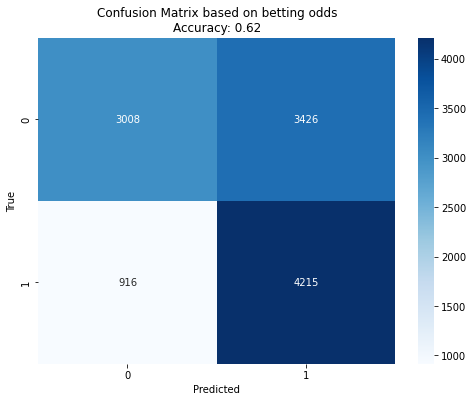

In [197]:
# Create a confusion matrix
bo_train = y_train
bo_train_calsses =  np.argmax(train_normalized_probas, axis=1)
conf_matrix = confusion_matrix(bo_train, bo_train_calsses )

# Calculate accuracy
accuracy = accuracy_score(bo_train, bo_train_calsses)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix based on betting odds\nAccuracy: {accuracy:.2f}')
plt.show()



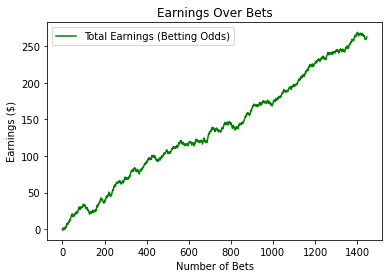

earned: 262.54


In [198]:
initial_dollar=1
predicted_bo = np.argmin(np.array(betting_data_test), axis=1)
bo_earnings = []

# Iterate through each data point for betting odds
for i in range(len(bo_labels)):
    
    if predicted_bo[i] == bo_labels[i]:
        bo_earnings.append(initial_dollar * (betting_data_test.at[i,predicted_bo[i]] - 1))
    else:
        bo_earnings.append(-initial_dollar)  # If the prediction is incorrect, earn nothing
total_bo_earnings = np.sum(bo_earnings)+initial_dollar
plt.plot(np.cumsum(bo_earnings) + initial_dollar, label='Total Earnings (Betting Odds)', color='green')
plt.xlabel('Number of Bets')
plt.ylabel('Earnings ($)')
plt.title('Earnings Over Bets')
plt.legend()
plt.show()
print('earned:',total_bo_earnings)

In [199]:
normalized_probas

array([[0.57142857, 0.42857143],
       [0.27480916, 0.72519084],
       [0.67241379, 0.32758621],
       ...,
       [0.1353001 , 0.8646999 ],
       [0.77355837, 0.22644163],
       [0.69421488, 0.30578512]])

In [200]:
betting_odds_auc = roc_auc_score(bo_labels, normalized_probas[:,1], multi_class='ovr')
print(f"betting odds AUC: {betting_odds_auc}")

betting odds AUC: 0.6997139016897082


In [201]:
betting_odds_auc = roc_auc_score(bo_train, train_normalized_probas[:,1], multi_class='ovr')
print(f"betting odds AUC: {betting_odds_auc}")

betting odds AUC: 0.7291934226589436


In [202]:
normalized_probas = np.array(normalized_probas)

In [203]:
normalized_probas

array([[0.57142857, 0.42857143],
       [0.27480916, 0.72519084],
       [0.67241379, 0.32758621],
       ...,
       [0.1353001 , 0.8646999 ],
       [0.77355837, 0.22644163],
       [0.69421488, 0.30578512]])

In [204]:
bo_classes = np.argmax(normalized_probas, axis=1)

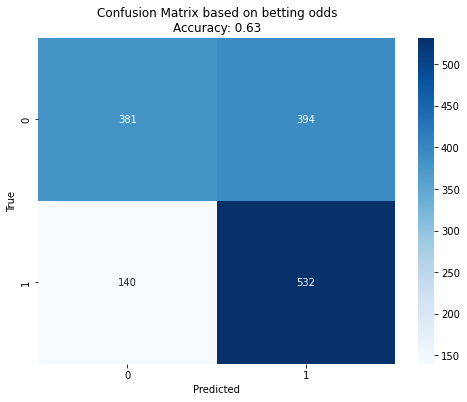

In [205]:
# Create a confusion matrix

conf_matrix = confusion_matrix(bo_labels, bo_classes)

# Calculate accuracy
accuracy = accuracy_score(bo_labels, bo_classes)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix based on betting odds\nAccuracy: {accuracy:.2f}')
plt.show()



Different way to model:
We can model the expected GD, and using that, we take the another model (svm or knn) to predict the outcome

In [206]:
X_train = train.copy()
X_test = test.copy()
# X_train.drop([ 'away_Points_form_pw',
#                  'home_points_to_championship',
#                 'home_points_to_ucl','home_points_to_rel','away_points_to_championship',
#              
#               'HomePlayer_Overall_mean_ln', 'AwayPlayer_Overall_mean_ln',
#               'Home_min_max','Away_min_max', 'capacity',
#               'AwayPlayer_Overall_min', 'HomePlayer_Overall_min'], inplace=True, axis=1)
# X_test.drop([ 'away_Points_form_pw',
#                  'home_points_to_championship',
#                 'home_points_to_ucl','home_points_to_rel','away_points_to_championship',
#                 'away_points_to_ucl',
#              'HomePlayer_Overall_mean_ln', 'AwayPlayer_Overall_mean_ln',  'Home_min_max','Away_min_max',
#               'AwayPlayer_Overall_min', 'HomePlayer_Overall_min','capacity',
#               ],inplace=True, axis=1)


In [207]:
scaler = StandardScaler()

train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(train_scaled, columns=X_train.columns)

test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(test_scaled, columns=X_train.columns)




In [208]:
print('home scoring avg:', ytrain_home.mean(),'\nwith an sd of:', ytrain_home.std())
print('away scoring avg:', ytrain_away.mean(),'\nwith an sd of:', ytrain_away.std())

home scoring avg: 1.5479463899697363 
with an sd of: 1.3139443092329939
away scoring avg: 1.2314742758322526 
with an sd of: 1.181085196651774


In [209]:
from sklearn.ensemble import RandomForestRegressor

home_reg = GridSearchCV(RandomForestRegressor(n_estimators=200),
                        param_grid= {'criterion': ['poisson'], 'max_depth': [5, 10, None], 'max_features': [0.02, 0.07, .15, .25, 0.3], 'max_samples': [0.5]},
                        scoring='neg_mean_squared_error', cv=3, verbose=3)

away_reg =GridSearchCV(RandomForestRegressor(n_estimators=200),
                        param_grid={'criterion': ['poisson'], 'max_depth': [5, 10, None], 'max_features': [0.02, 0.07, .15,.25, 0.3], 'max_samples': [0.25]},
                        scoring='neg_mean_squared_error', cv=3, verbose=3)


home_reg.fit(train, ytrain_home)
away_reg.fit(train, ytrain_away)
'''
best hyper parameters for home regression: {'criterion': 'poisson', 'max_depth': 5, 'max_features': 0.3, 'max_samples': 0.5}
best parameters for away reg: {'criterion': 'poisson', 'max_depth': 5, 'max_features': 0.3, 'max_samples': 0.25}
'''

print("best hyper parameters for home regression:", home_reg.best_params_)
print("best parameters for away reg:", away_reg.best_params_)
home_train = home_reg.predict(train)
away_train = away_reg.predict(train)

home_test = home_reg.predict(test)
away_test = away_reg.predict(test)
print('train home rmse:', np.sqrt(mean_squared_error(ytrain_home, home_train)))
print('train away rmse:', np.sqrt(mean_squared_error(ytrain_away, away_train)))

print('test home rmse:', np.sqrt(mean_squared_error(ytest_home, home_test)))
print('test away rmse:', np.sqrt(mean_squared_error(ytest_away, away_test)))


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END criterion=poisson, max_depth=5, max_features=0.02, max_samples=0.5;, score=-1.500 total time=   0.8s
[CV 2/3] END criterion=poisson, max_depth=5, max_features=0.02, max_samples=0.5;, score=-1.452 total time=   0.8s
[CV 3/3] END criterion=poisson, max_depth=5, max_features=0.02, max_samples=0.5;, score=-1.471 total time=   0.9s
[CV 1/3] END criterion=poisson, max_depth=5, max_features=0.07, max_samples=0.5;, score=-1.499 total time=   0.7s
[CV 2/3] END criterion=poisson, max_depth=5, max_features=0.07, max_samples=0.5;, score=-1.454 total time=   0.8s
[CV 3/3] END criterion=poisson, max_depth=5, max_features=0.07, max_samples=0.5;, score=-1.475 total time=   0.9s
[CV 1/3] END criterion=poisson, max_depth=5, max_features=0.15, max_samples=0.5;, score=-1.499 total time=   0.8s
[CV 2/3] END criterion=poisson, max_depth=5, max_features=0.15, max_samples=0.5;, score=-1.452 total time=   0.7s
[CV 3/3] END criterion=poiss

KeyboardInterrupt: 

In [150]:
def plot_by_matchweek(actual, output, weeks, title=''):
    df = pd.DataFrame({
        'Matchweek' : weeks.values,
        'output' : output,
        'actual' : actual
    })
    df['se'] = (actual -output) ** 2
    mse_by_week = df.groupby('Matchweek')['se'].mean()
    # Plot the MSE by matchweek
    plt.figure(figsize=(10, 6))
    plt.plot(mse_by_week.index, mse_by_week.values, marker='o')
    plt.title(title)
    plt.xlabel('Matchweek')
    plt.ylabel('Mean Squared Error')
    plt.grid(True)
    plt.show()


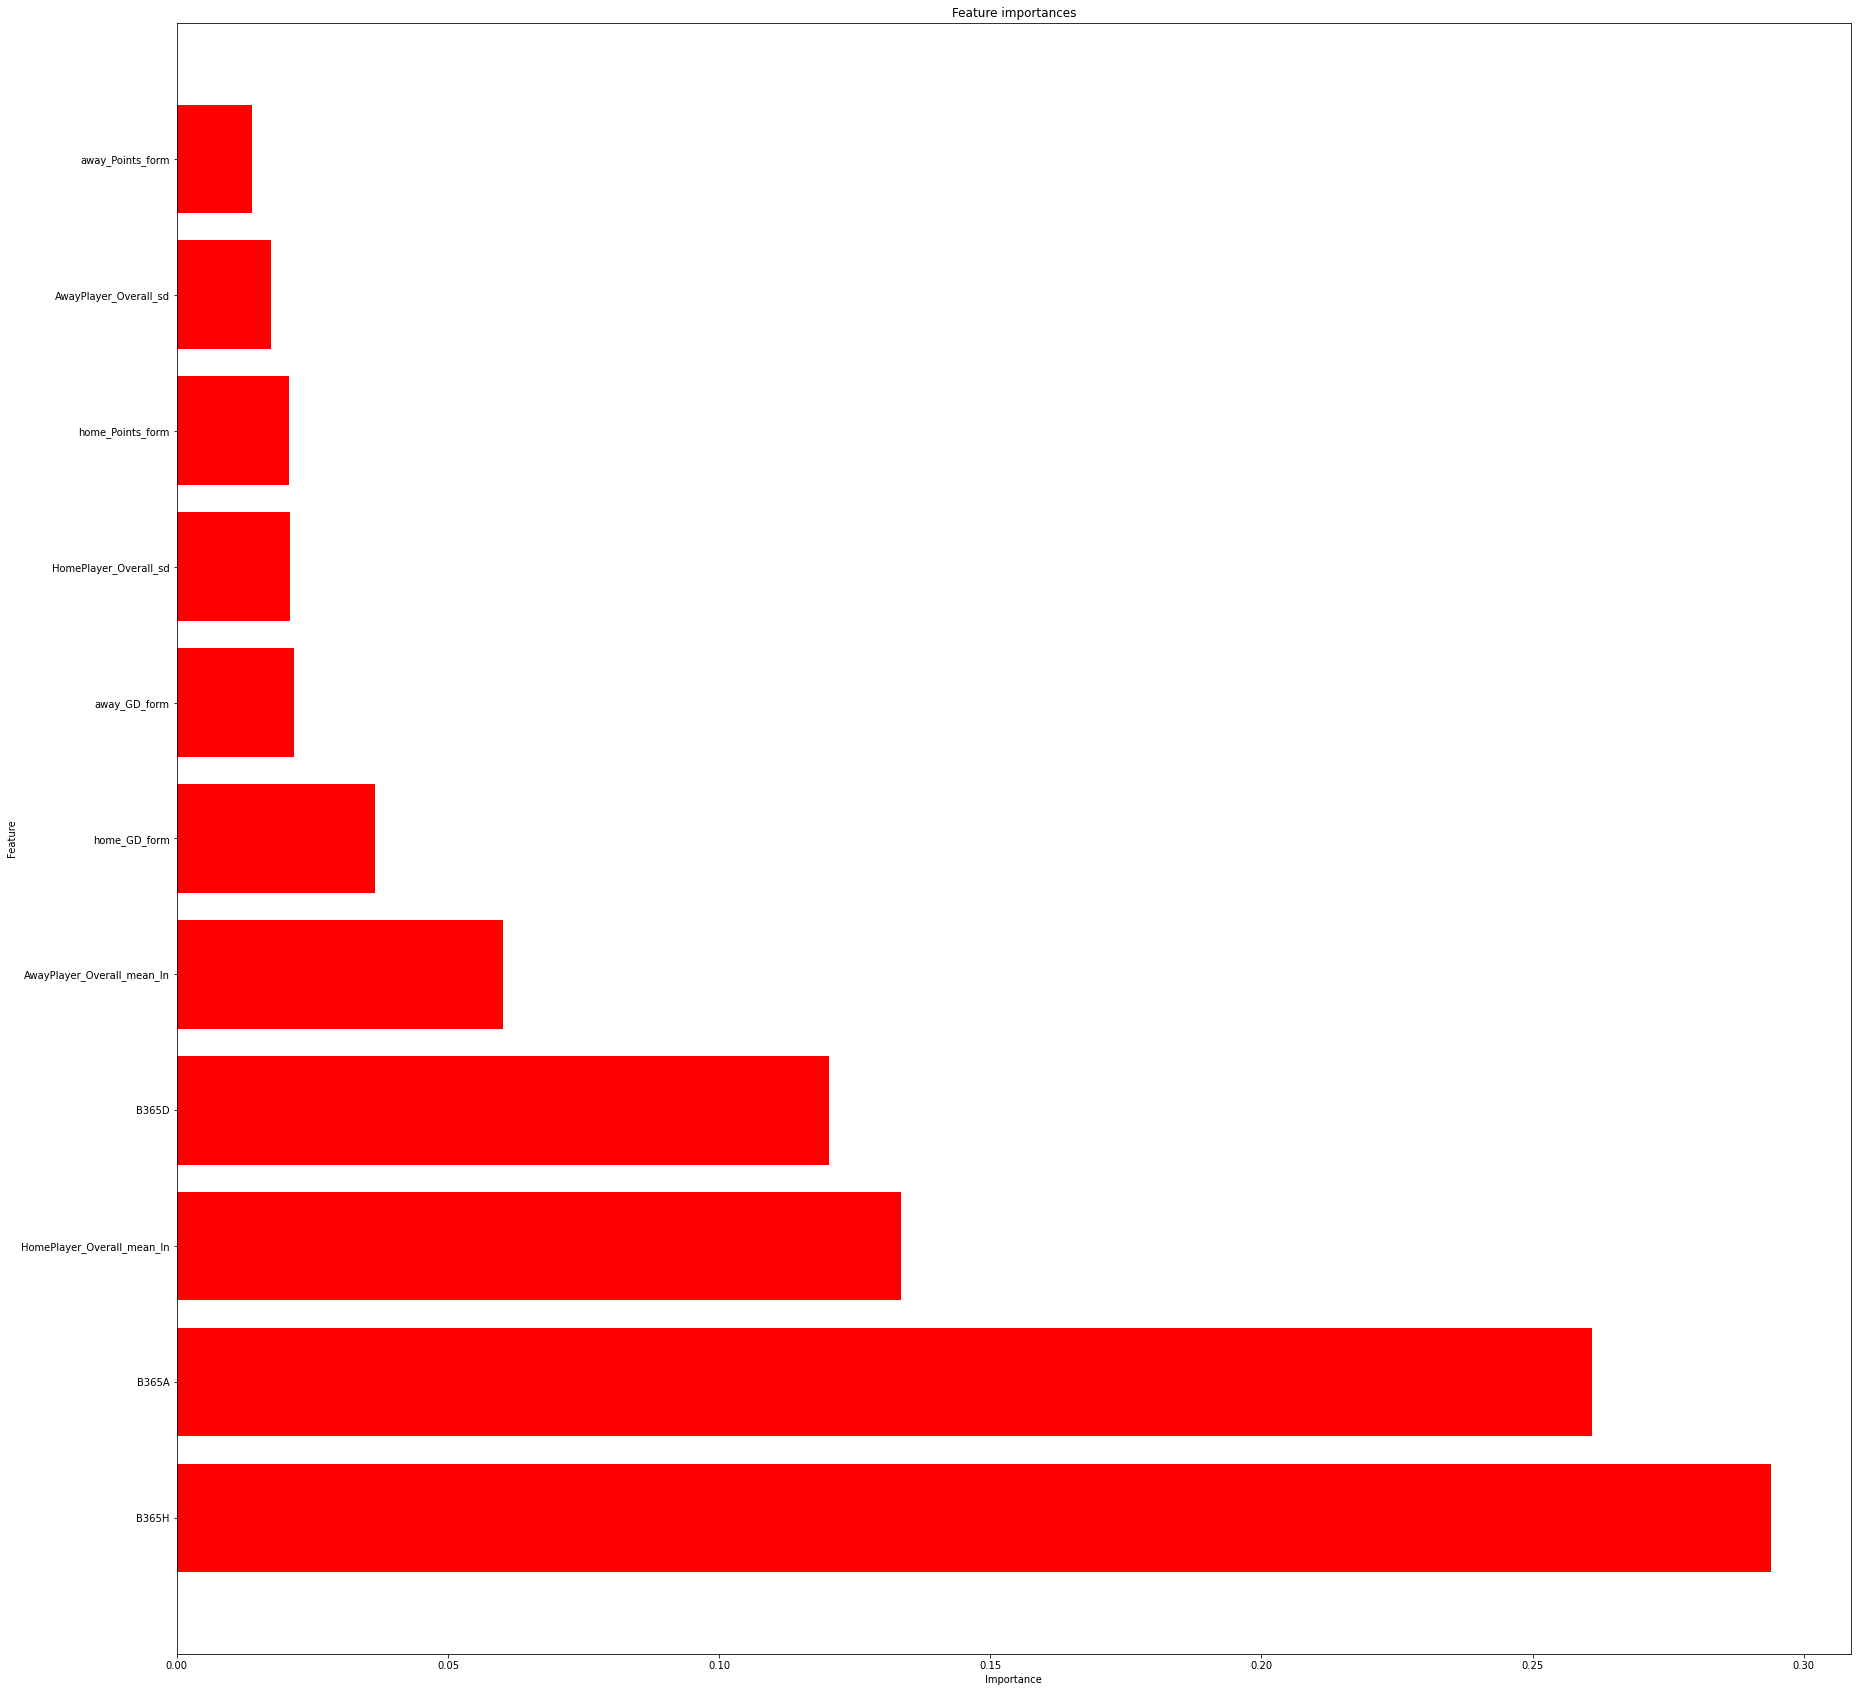

best hyper parameters for home regression: {'criterion': 'poisson', 'max_depth': 5, 'max_features': 0.3, 'max_samples': 0.5}
best parameters for away reg: {'criterion': 'poisson', 'max_depth': 5, 'max_features': 0.3, 'max_samples': 0.25}
train home rmse: 1.1850323288812055
train away rmse: 1.0852753308994156
test home rmse: 1.2438404517619468
test away rmse: 1.0668256411309076
(1447, 2)
for Test season, going via accuracy strategy, we earn:  552.5300000000008
for Test season going by max returns strategy, we earn:  1199.1100000000001
for Test season, going with ln risk aversion strategy, we earn:  1210.5700000000002
for Test season, going with sqrt risk aversion strategy, we earn:  1103.6199999999994
for Test season, going with sqrt risk aversion of profits strategy, we earn:  1165.6499999999999
for Test season, going for rev^proba of bet365 strategy, we earn:  905.9300000000011
for Test season, going via sharpe ratio strategy, we earn:  1097.12


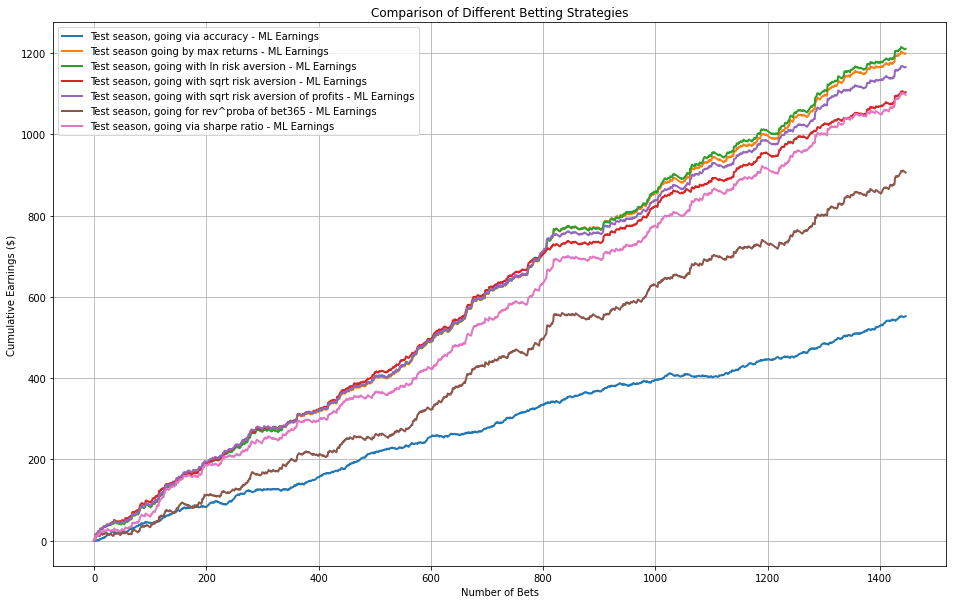

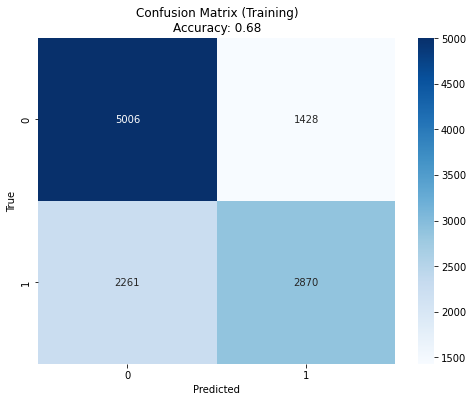

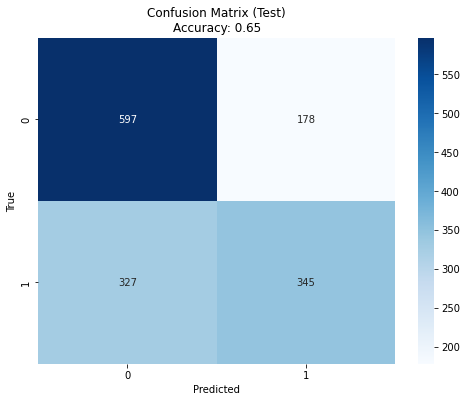

Training OvR AUC: 0.7366378865638215
Test OvR AUC: 0.7027976190476191


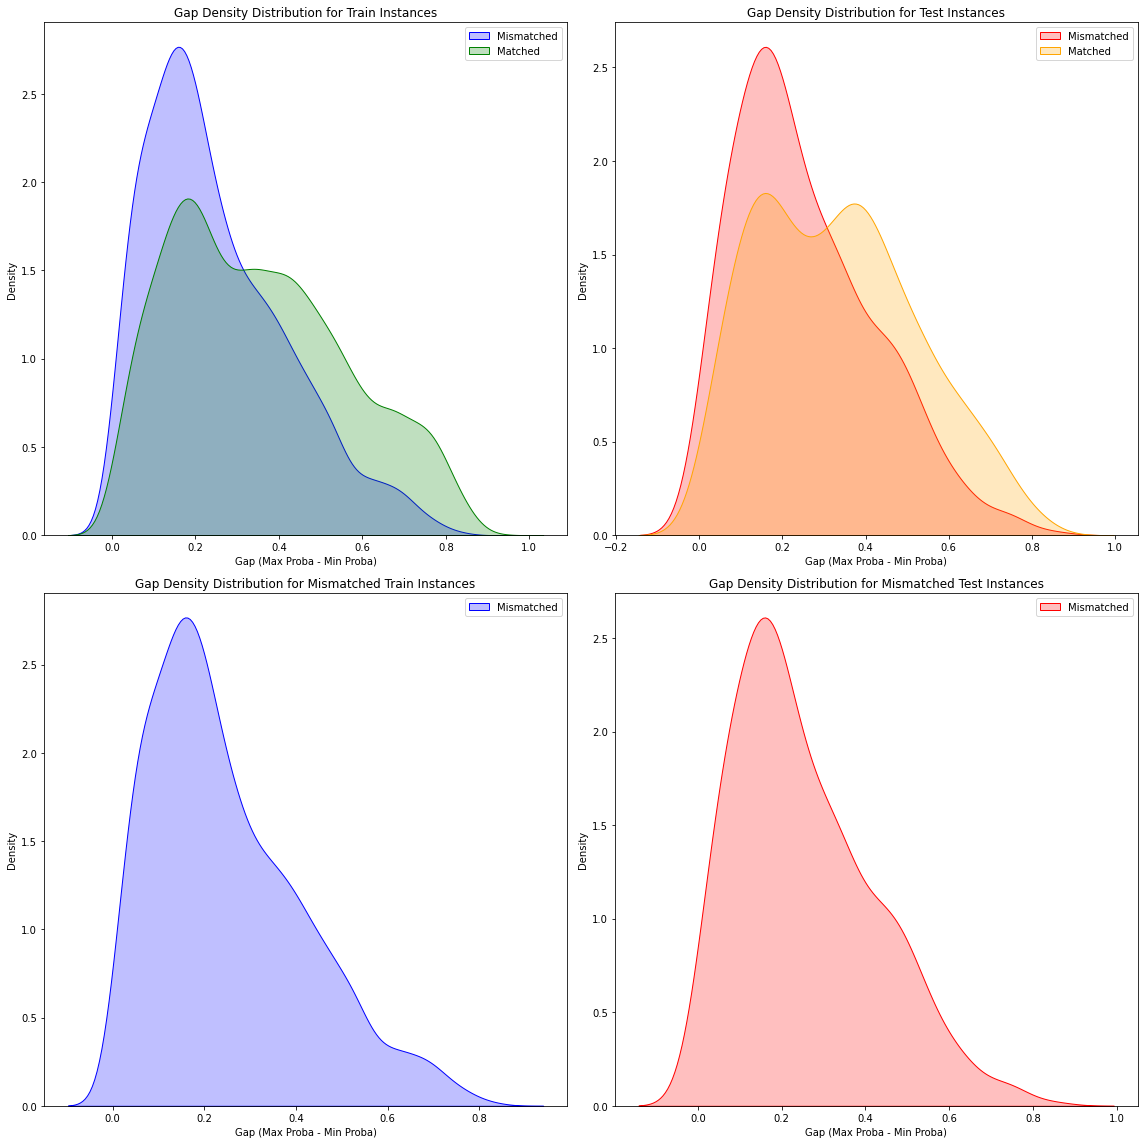

"\nbest hyper parameters for home regression: {'criterion': 'poisson', 'max_depth': 5, 'max_features': 0.3333333333333333, 'max_samples': 0.15}\nbest parameters for away reg: {'criterion': 'poisson', 'max_depth': 5, 'max_features': 0.3333333333333333, 'max_samples': 0.2}\n"

In [151]:

# Get feature importances
importances = home_reg.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = train.columns[indices]

# Plot the feature importances
plt.figure(figsize=(30,30))
plt.title("Feature importances")
plt.barh(range(train.shape[1]), importances[indices], color="r", align="center")
plt.yticks(range(train.shape[1]), feature_names)
plt.ylim([-1, train.shape[1]])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

print("best hyper parameters for home regression:", home_reg.best_params_)
print("best parameters for away reg:", away_reg.best_params_)

home_train = home_reg.predict(train)
away_train = away_reg.predict(train)

# plot_by_matchweek(ytrain_home, home_train, train['Matchweek'], 'MSE By machweek for home regression')
# plot_by_matchweek(ytrain_away, away_train, train['Matchweek'], 'MSE By machweek for away regression')

home_test = home_reg.predict(test)
away_test = away_reg.predict(test)

# plot_by_matchweek(ytest_home, home_test, test['Matchweek'], 'MSE By machweek for home regression')
# plot_by_matchweek(ytest_away, away_test, test['Matchweek'], 'MSE By machweek for away regression')

print('train home rmse:', np.sqrt(mean_squared_error(ytrain_home, home_train)))
print('train away rmse:', np.sqrt(mean_squared_error(ytrain_away, away_train)))

print('test home rmse:', np.sqrt(mean_squared_error(ytest_home, home_test)))
print('test away rmse:', np.sqrt(mean_squared_error(ytest_away, away_test)))

train_probas = extract_poisson_probas_binary(home_train, away_train)
test_probas = extract_poisson_probas_binary(home_test, away_test)

sharpe_ratios = np.asarray(test_probas*(betting_data_test**2 - test_probas*(betting_data_test**2) + 2*test_probas*betting_data_test - 1))
print(sharpe_ratios.shape)
# bet_and_plot_thresh(test_probas, y_test, betting_data, normalized_probas, extra_title=' Test season, going via accuracy')
# bet_and_plot_thresh(np.asarray(betting_data)*test_probas, y_test, betting_data, normalized_probas, extra_title=' Test season going by max returns', threshold =1)
# bet_and_plot_thresh(test_probas*np.log(np.asarray(betting_data)), y_test, betting_data, normalized_probas, extra_title=' Test season, going with ln risk aversion', threshold=0)
# bet_and_plot_thresh(test_probas*np.sqrt(np.asarray(betting_data)), y_test, betting_data, normalized_probas, extra_title=' Test season, going with sqrt risk aversion', threshold=0)
# bet_and_plot_thresh(test_probas*np.sqrt(np.asarray(betting_data)-1), y_test, betting_data, normalized_probas, extra_title=' Test season, going with sqrt risk aversion', threshold=0)

# bet_and_plot_thresh(np.power(np.asarray(betting_data),normalized_probas), y_test, betting_data, normalized_probas, extra_title=' Test season, going for rev^proba of bet365', threshold=1)
# bet_and_plot_thresh(sharpe_ratios, y_test, betting_data, normalized_probas, extra_title=' Test season, going via sharpe ratio')

strategies = []

strategies.append(bet_thresh(test_probas, y_test, betting_data_test, normalized_probas, extra_title='Test season, going via accuracy'))
strategies.append(bet_thresh(np.asarray(betting_data_test)*test_probas, y_test, betting_data_test, normalized_probas, extra_title='Test season going by max returns', threshold=1))
strategies.append(bet_thresh(test_probas*np.log(np.asarray(betting_data_test)), y_test, betting_data_test, normalized_probas, extra_title='Test season, going with ln risk aversion', threshold=0))
strategies.append(bet_thresh(test_probas*np.sqrt(np.asarray(betting_data_test)), y_test, betting_data_test, normalized_probas, extra_title='Test season, going with sqrt risk aversion', threshold=0))
strategies.append(bet_thresh(test_probas*np.sqrt(np.asarray(betting_data_test)-1), y_test, betting_data_test, normalized_probas, extra_title='Test season, going with sqrt risk aversion of profits', threshold=0))

strategies.append(bet_thresh(np.power(np.asarray(betting_data_test),normalized_probas), y_test, betting_data_test, normalized_probas, extra_title='Test season, going for rev^proba of bet365', threshold=1))
strategies.append(bet_thresh(sharpe_ratios, y_test, betting_data_test, normalized_probas, extra_title='Test season, going via sharpe ratio'))
plt.figure(figsize=(16, 10))

for cum_earnings, cum_bo_earnings, cum_delta_earnings, title in strategies:
    print('for '+title+' strategy, we earn: ',cum_earnings[-1])
    plt.plot(cum_earnings, label=f'{title} - ML Earnings', linestyle='-', linewidth=2)
    #plt.plot(cum_bo_earnings, label=f'{title} - Betting Odds Earnings', linestyle='--', linewidth=2)
    #plt.plot(cum_delta_earnings, label=f'{title} - Delta Earnings', linestyle=':', linewidth=2)

plt.xlabel('Number of Bets')
plt.ylabel('Cumulative Earnings ($)')
plt.title('Comparison of Different Betting Strategies')
plt.legend(loc='best')
plt.grid(True)
plt.show()

train_classes = np.argmax(train_probas, axis=1)
train_classes = train_classes

# Create a confusion matrix
conf_matrix = confusion_matrix(y_train, train_classes)

# Calculate accuracy
accuracy = accuracy_score(y_train, train_classes)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Training)\nAccuracy: {accuracy:.2f}')
plt.show()

test_classes = np.argmax(test_probas, axis=1)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, test_classes)

# Calculate accuracy
accuracy = accuracy_score(y_test, test_classes)


# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Test)\nAccuracy: {accuracy:.2f}')
plt.show()
train_auc_ovr = roc_auc_score(y_train, train_probas[:,1])
print(f"Training OvR AUC: {train_auc_ovr}")

# Calculate OvO AUC for the test set
test_auc_ovr = roc_auc_score(y_test, test_probas[:,1])
print(f"Test OvR AUC: {test_auc_ovr}")

train_bets = np.asarray(train[['B365A','B365D', 'B365A']])
# Calculate the max and min probabilities
train_max_proba = np.max(train_probas, axis=1)
train_min_proba = np.sort(train_probas, axis=1)[:, ::-1][:,1]
test_max_proba = np.max(test_probas, axis=1)
test_min_proba = np.sort(test_probas, axis=1)[:, ::-1][:,1]

# Calculate the gaps
train_gaps = train_max_proba - train_min_proba
test_gaps = test_max_proba - test_min_proba

# Get predicted labels
train_preds = np.argmax(train_probas, axis=1)
test_preds = np.argmax(test_probas, axis=1)

# Identify mismatches
train_mismatches = train_preds != y_train
test_mismatches = test_preds != y_test

# Identify matches
train_matches = train_preds == y_train
test_matches = test_preds == y_test

# Filter gaps for mismatched and matched instances
train_mismatch_gaps = train_gaps[train_mismatches]
test_mismatch_gaps = test_gaps[test_mismatches]
train_match_gaps = train_gaps[train_matches]
test_match_gaps = test_gaps[test_matches]

# Plot the density distributions
plt.figure(figsize=(16, 16))

plt.subplot(2, 2, 1)
sns.kdeplot(train_mismatch_gaps, fill=True, color='blue', label='Mismatched')
sns.kdeplot(train_match_gaps, fill=True, color='green', label='Matched')
plt.xlabel('Gap (Max Proba - Min Proba)')
plt.ylabel('Density')
plt.title('Gap Density Distribution for Train Instances')
plt.legend()

plt.subplot(2, 2, 2)
sns.kdeplot(test_mismatch_gaps, fill=True, color='red', label='Mismatched')
sns.kdeplot(test_match_gaps, fill=True, color='orange', label='Matched')
plt.xlabel('Gap (Max Proba - Min Proba)')
plt.ylabel('Density')
plt.title('Gap Density Distribution for Test Instances')
plt.legend()

plt.subplot(2, 2, 3)
sns.kdeplot(train_mismatch_gaps, fill=True, color='blue', label='Mismatched')
plt.xlabel('Gap (Max Proba - Min Proba)')
plt.ylabel('Density')
plt.title('Gap Density Distribution for Mismatched Train Instances')
plt.legend()

plt.subplot(2, 2, 4)
sns.kdeplot(test_mismatch_gaps, fill=True, color='red', label='Mismatched')
plt.xlabel('Gap (Max Proba - Min Proba)')
plt.ylabel('Density')
plt.title('Gap Density Distribution for Mismatched Test Instances')
plt.legend()

plt.tight_layout()
plt.show()
'''
best hyper parameters for home regression: {'criterion': 'poisson', 'max_depth': 5, 'max_features': 0.3333333333333333, 'max_samples': 0.15}
best parameters for away reg: {'criterion': 'poisson', 'max_depth': 5, 'max_features': 0.3333333333333333, 'max_samples': 0.2}
'''

In [152]:
# # ## Save the model

with open('RFHome.pkl', 'wb') as f:
    pickle.dump(home_reg.best_estimator_, f)

with open('RFAway.pkl', 'wb') as f:
    pickle.dump(away_reg.best_estimator_, f)


In [153]:
from xgboost import XGBRegressor

home_reg = GridSearchCV(XGBRegressor(eval_metric ='poisson-nloglik'),
                        param_grid={'colsample_bytree': [0.5], 'max_depth': [1], 'n_estimators': [70], 'objective': ['count:poisson'], 'subsample': [1, .75, .5]},
                        scoring='neg_mean_squared_error', cv=3, verbose=3)

away_reg =GridSearchCV(XGBRegressor(eval_metric ='poisson-nloglik'),
                        param_grid={'colsample_bytree': [0.5], 'max_depth': [1], 'n_estimators': [130], 'objective': ['count:poisson'], 'subsample': [1, .75, .5]},
                        scoring='neg_mean_squared_error', cv=3, verbose=3)



home_reg.fit(train, ytrain_home)
away_reg.fit(train, ytrain_away)


print("best hyper parameters for home regression:", home_reg.best_params_)
print("best parameters for away reg:", away_reg.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END colsample_bytree=0.5, max_depth=1, n_estimators=70, objective=count:poisson, subsample=1;, score=-1.465 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, max_depth=1, n_estimators=70, objective=count:poisson, subsample=1;, score=-1.446 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, max_depth=1, n_estimators=70, objective=count:poisson, subsample=1;, score=-1.455 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, max_depth=1, n_estimators=70, objective=count:poisson, subsample=0.75;, score=-1.455 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, max_depth=1, n_estimators=70, objective=count:poisson, subsample=0.75;, score=-1.451 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, max_depth=1, n_estimators=70, objective=count:poisson, subsample=0.75;, score=-1.458 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, max_depth=1, n_estimators=70, objective=count:poisson, subsample=0.5;, score=-1.4

best hyper parameters for home regression: {'colsample_bytree': 0.5, 'max_depth': 1, 'n_estimators': 70, 'objective': 'count:poisson', 'subsample': 0.75}
best parameters for away reg: {'colsample_bytree': 0.5, 'max_depth': 1, 'n_estimators': 130, 'objective': 'count:poisson', 'subsample': 1}
train home rmse: 1.1984060645875592
train away rmse: 1.0922227694076063
test home rmse: 1.2464198468345964
test away rmse: 1.0663248763035091
(1447, 2)
for Test season, going via accuracy strategy, we earn:  542.3300000000007
for Test season going by max returns strategy, we earn:  1195.1699999999998
for Test season, going with ln risk aversion strategy, we earn:  1200.9499999999998
for Test season, going with sqrt risk aversion strategy, we earn:  1068.4300000000007
for Test season, going with sqrt risk aversion of profits strategy, we earn:  1169.4799999999996
for Test season, going for rev^proba of bet365 strategy, we earn:  905.9300000000011
for Test season, going via sharpe ratio strategy, we 

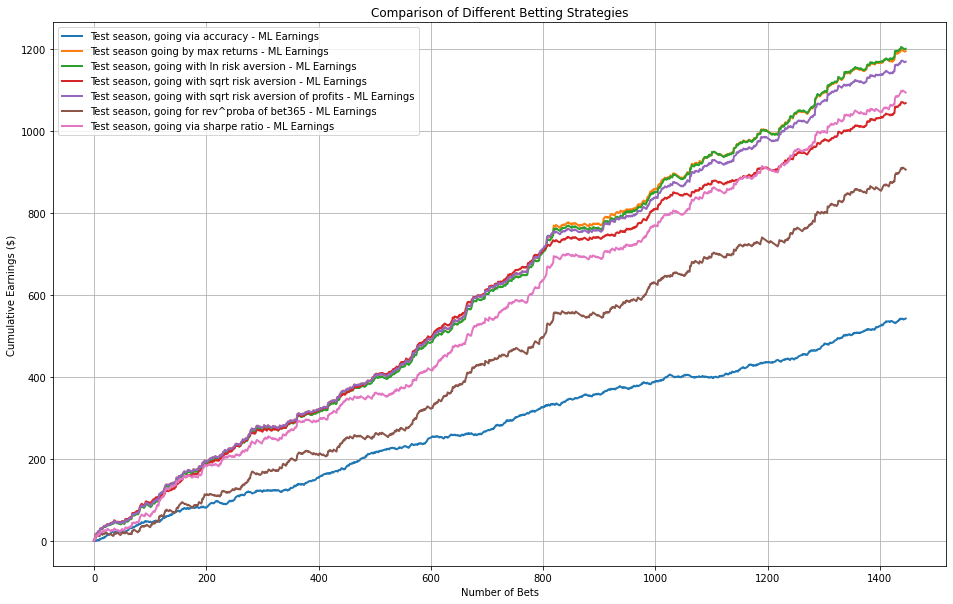

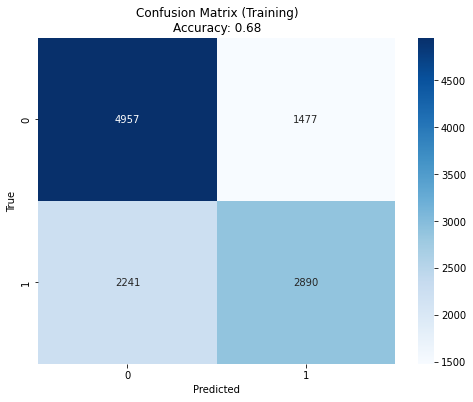

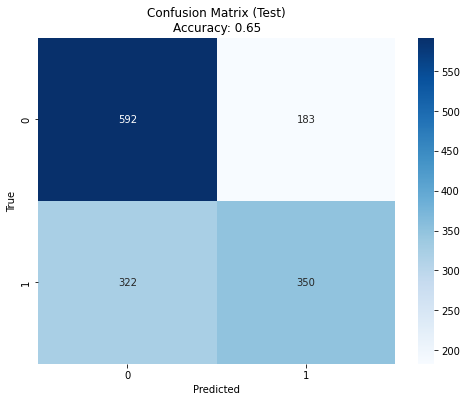

Training OvR AUC: 0.7319240257143476
Test OvR AUC: 0.7039679339477727


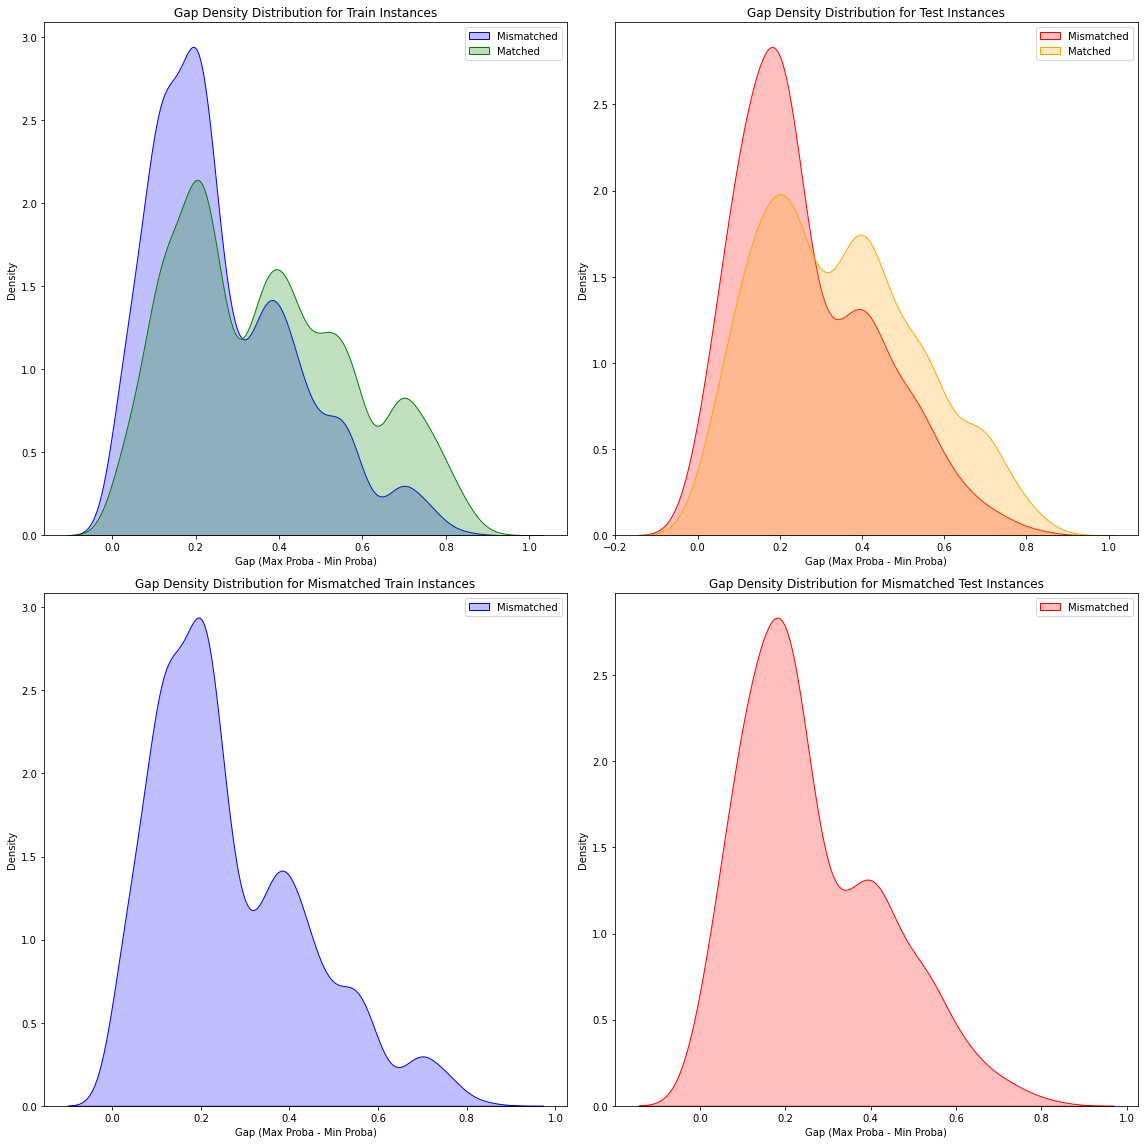

<ipython-input-154-8e06d1a34b52>:200: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_mismatch_gaps, shade=True, color='blue', label='Mismatched')
<ipython-input-154-8e06d1a34b52>:201: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_match_gaps, shade=True, color='green', label='Matched')
<ipython-input-154-8e06d1a34b52>:208: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_mismatch_gaps, shade=True, color='red', label='Mismatched')
<ipython-input-154-8e06d1a34b52>:209: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update 

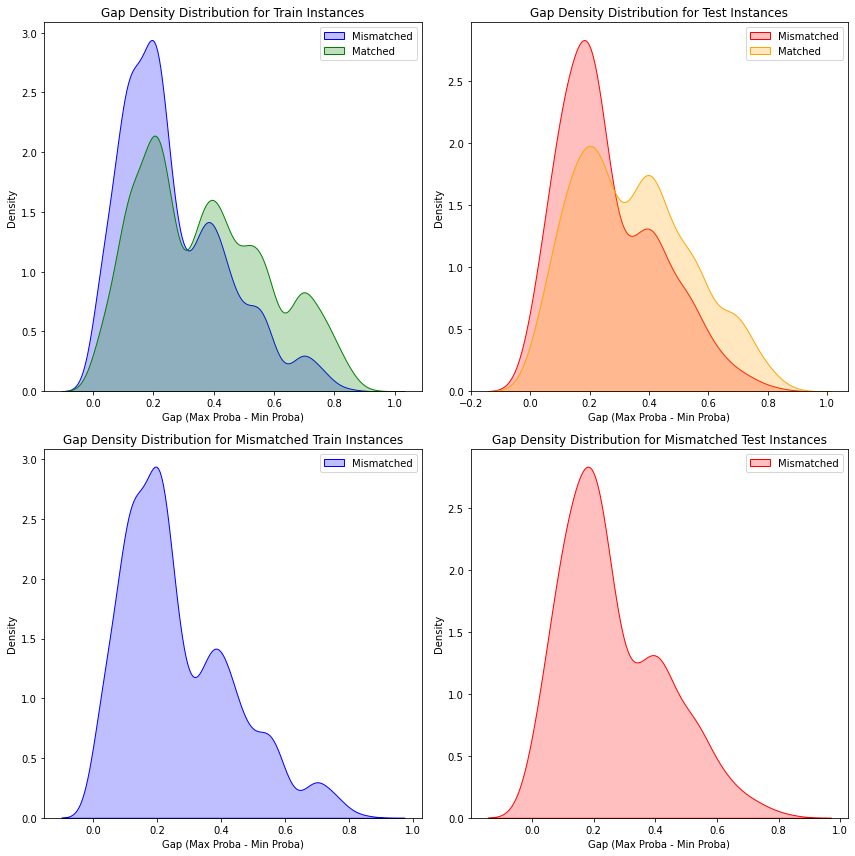

"\nbest hyper parameters for home regression: {'max_depth': 1, 'n_estimators': 100, 'objective': 'count:poisson', 'subsample': 0.5}\nbest parameters for away reg: {'max_depth': 1, 'n_estimators': 50, 'objective': 'count:poisson', 'subsample': 0.5}\n"

In [154]:

print("best hyper parameters for home regression:", home_reg.best_params_)
print("best parameters for away reg:", away_reg.best_params_)

home_train = home_reg.predict(train)
away_train = away_reg.predict(train)

# plot_by_matchweek(ytrain_home, home_train, train['Matchweek'], 'MSE By machweek for home regression')
# plot_by_matchweek(ytrain_away, away_train, train['Matchweek'], 'MSE By machweek for away regression')

home_test = home_reg.predict(test)
away_test = away_reg.predict(test)

# plot_by_matchweek(ytest_home, home_test, test['Matchweek'], 'MSE By machweek for home regression')
# plot_by_matchweek(ytest_away, away_test, test['Matchweek'], 'MSE By machweek for away regression')

print('train home rmse:', np.sqrt(mean_squared_error(ytrain_home, home_train)))
print('train away rmse:', np.sqrt(mean_squared_error(ytrain_away, away_train)))

print('test home rmse:', np.sqrt(mean_squared_error(ytest_home, home_test)))
print('test away rmse:', np.sqrt(mean_squared_error(ytest_away, away_test)))

train_probas = extract_poisson_probas_binary(home_train, away_train)
test_probas = extract_poisson_probas_binary(home_test, away_test)

sharpe_ratios = np.asarray(test_probas*(betting_data_test**2 - test_probas*(betting_data_test**2) + 2*test_probas*betting_data_test - 1))
print(sharpe_ratios.shape)
# bet_and_plot_thresh(test_probas, y_test, betting_data, normalized_probas, extra_title=' Test season, going via accuracy')
# bet_and_plot_thresh(np.asarray(betting_data)*test_probas, y_test, betting_data, normalized_probas, extra_title=' Test season going by max returns', threshold =1)
# bet_and_plot_thresh(test_probas*np.log(np.asarray(betting_data)), y_test, betting_data, normalized_probas, extra_title=' Test season, going with ln risk aversion', threshold=0)
# bet_and_plot_thresh(test_probas*np.sqrt(np.asarray(betting_data)), y_test, betting_data, normalized_probas, extra_title=' Test season, going with sqrt risk aversion', threshold=0)
# bet_and_plot_thresh(test_probas*np.sqrt(np.asarray(betting_data)-1), y_test, betting_data, normalized_probas, extra_title=' Test season, going with sqrt risk aversion', threshold=0)

# bet_and_plot_thresh(np.power(np.asarray(betting_data),normalized_probas), y_test, betting_data, normalized_probas, extra_title=' Test season, going for rev^proba of bet365', threshold=1)
# bet_and_plot_thresh(sharpe_ratios, y_test, betting_data, normalized_probas, extra_title=' Test season, going via sharpe ratio')

strategies = []

strategies.append(bet_thresh(test_probas, y_test, betting_data_test, normalized_probas, extra_title='Test season, going via accuracy'))
strategies.append(bet_thresh(np.asarray(betting_data_test)*test_probas, y_test, betting_data_test, normalized_probas, extra_title='Test season going by max returns', threshold=1))
strategies.append(bet_thresh(test_probas*np.log(np.asarray(betting_data_test)), y_test, betting_data_test, normalized_probas, extra_title='Test season, going with ln risk aversion', threshold=0))
strategies.append(bet_thresh(test_probas*np.sqrt(np.asarray(betting_data_test)), y_test, betting_data_test, normalized_probas, extra_title='Test season, going with sqrt risk aversion', threshold=0))
strategies.append(bet_thresh(test_probas*np.sqrt(np.asarray(betting_data_test)-1), y_test, betting_data_test, normalized_probas, extra_title='Test season, going with sqrt risk aversion of profits', threshold=0))

strategies.append(bet_thresh(np.power(np.asarray(betting_data_test),normalized_probas), y_test, betting_data_test, normalized_probas, extra_title='Test season, going for rev^proba of bet365', threshold=1))
strategies.append(bet_thresh(sharpe_ratios, y_test, betting_data_test, normalized_probas, extra_title='Test season, going via sharpe ratio'))
plt.figure(figsize=(16, 10))

for cum_earnings, cum_bo_earnings, cum_delta_earnings, title in strategies:
    print('for '+title+' strategy, we earn: ',cum_earnings[-1])
    plt.plot(cum_earnings, label=f'{title} - ML Earnings', linestyle='-', linewidth=2)
    #plt.plot(cum_bo_earnings, label=f'{title} - Betting Odds Earnings', linestyle='--', linewidth=2)
    #plt.plot(cum_delta_earnings, label=f'{title} - Delta Earnings', linestyle=':', linewidth=2)

plt.xlabel('Number of Bets')
plt.ylabel('Cumulative Earnings ($)')
plt.title('Comparison of Different Betting Strategies')
plt.legend(loc='best')
plt.grid(True)
plt.show()

train_classes = np.argmax(train_probas, axis=1)
train_classes = train_classes

# Create a confusion matrix
conf_matrix = confusion_matrix(y_train, train_classes)

# Calculate accuracy
accuracy = accuracy_score(y_train, train_classes)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Training)\nAccuracy: {accuracy:.2f}')
plt.show()

test_classes = np.argmax(test_probas, axis=1)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, test_classes)

# Calculate accuracy
accuracy = accuracy_score(y_test, test_classes)


# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Test)\nAccuracy: {accuracy:.2f}')
plt.show()
train_auc_ovr = roc_auc_score(y_train, train_probas[:,1])
print(f"Training OvR AUC: {train_auc_ovr}")

# Calculate OvO AUC for the test set
test_auc_ovr = roc_auc_score(y_test, test_probas[:,1])
print(f"Test OvR AUC: {test_auc_ovr}")

train_bets = np.asarray(train[['B365A','B365D', 'B365A']])
# Calculate the max and min probabilities
train_max_proba = np.max(train_probas, axis=1)
train_min_proba = np.sort(train_probas, axis=1)[:, ::-1][:,1]
test_max_proba = np.max(test_probas, axis=1)
test_min_proba = np.sort(test_probas, axis=1)[:, ::-1][:,1]

# Calculate the gaps
train_gaps = train_max_proba - train_min_proba
test_gaps = test_max_proba - test_min_proba

# Get predicted labels
train_preds = np.argmax(train_probas, axis=1)
test_preds = np.argmax(test_probas, axis=1)

# Identify mismatches
train_mismatches = train_preds != y_train
test_mismatches = test_preds != y_test

# Identify matches
train_matches = train_preds == y_train
test_matches = test_preds == y_test

# Filter gaps for mismatched and matched instances
train_mismatch_gaps = train_gaps[train_mismatches]
test_mismatch_gaps = test_gaps[test_mismatches]
train_match_gaps = train_gaps[train_matches]
test_match_gaps = test_gaps[test_matches]

# Plot the density distributions
plt.figure(figsize=(16, 16))

plt.subplot(2, 2, 1)
sns.kdeplot(train_mismatch_gaps, fill=True, color='blue', label='Mismatched')
sns.kdeplot(train_match_gaps, fill=True, color='green', label='Matched')
plt.xlabel('Gap (Max Proba - Min Proba)')
plt.ylabel('Density')
plt.title('Gap Density Distribution for Train Instances')
plt.legend()

plt.subplot(2, 2, 2)
sns.kdeplot(test_mismatch_gaps, fill=True, color='red', label='Mismatched')
sns.kdeplot(test_match_gaps, fill=True, color='orange', label='Matched')
plt.xlabel('Gap (Max Proba - Min Proba)')
plt.ylabel('Density')
plt.title('Gap Density Distribution for Test Instances')
plt.legend()

plt.subplot(2, 2, 3)
sns.kdeplot(train_mismatch_gaps, fill=True, color='blue', label='Mismatched')
plt.xlabel('Gap (Max Proba - Min Proba)')
plt.ylabel('Density')
plt.title('Gap Density Distribution for Mismatched Train Instances')
plt.legend()

plt.subplot(2, 2, 4)
sns.kdeplot(test_mismatch_gaps, fill=True, color='red', label='Mismatched')
plt.xlabel('Gap (Max Proba - Min Proba)')
plt.ylabel('Density')
plt.title('Gap Density Distribution for Mismatched Test Instances')
plt.legend()

plt.tight_layout()
plt.show()

train_bets = np.asarray(train[['B365A','B365D', 'B365A']])
# Calculate the max and min probabilities
train_max_proba = np.max(train_probas, axis=1)
train_min_proba = np.sort(train_probas, axis=1)[:, ::-1][:,1]
test_max_proba = np.max(test_probas, axis=1)
test_min_proba = np.sort(test_probas, axis=1)[:, ::-1][:,1]


# Calculate the gaps
train_gaps = train_max_proba - train_min_proba
test_gaps = test_max_proba - test_min_proba

# Get predicted labels
train_preds = np.argmax(train_probas, axis=1)
test_preds = np.argmax(test_probas, axis=1)

# Identify mismatches
train_mismatches = train_preds != y_train
test_mismatches = test_preds != y_test

# Identify matches
train_matches = train_preds == y_train
test_matches = test_preds == y_test

# Filter gaps for mismatched and matched instances
train_mismatch_gaps = train_gaps[train_mismatches]
test_mismatch_gaps = test_gaps[test_mismatches]
train_match_gaps = train_gaps[train_matches]
test_match_gaps = test_gaps[test_matches]

# Plot the density distributions
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
sns.kdeplot(train_mismatch_gaps, shade=True, color='blue', label='Mismatched')
sns.kdeplot(train_match_gaps, shade=True, color='green', label='Matched')
plt.xlabel('Gap (Max Proba - Min Proba)')
plt.ylabel('Density')
plt.title('Gap Density Distribution for Train Instances')
plt.legend()

plt.subplot(2, 2, 2)
sns.kdeplot(test_mismatch_gaps, shade=True, color='red', label='Mismatched')
sns.kdeplot(test_match_gaps, shade=True, color='orange', label='Matched')
plt.xlabel('Gap (Max Proba - Min Proba)')
plt.ylabel('Density')
plt.title('Gap Density Distribution for Test Instances')
plt.legend()

plt.subplot(2, 2, 3)
sns.kdeplot(train_mismatch_gaps, shade=True, color='blue', label='Mismatched')
plt.xlabel('Gap (Max Proba - Min Proba)')
plt.ylabel('Density')
plt.title('Gap Density Distribution for Mismatched Train Instances')
plt.legend()

plt.subplot(2, 2, 4)
sns.kdeplot(test_mismatch_gaps, shade=True, color='red', label='Mismatched')
plt.xlabel('Gap (Max Proba - Min Proba)')
plt.ylabel('Density')
plt.title('Gap Density Distribution for Mismatched Test Instances')
plt.legend()

plt.tight_layout()
plt.show()
'''
best hyper parameters for home regression: {'max_depth': 1, 'n_estimators': 100, 'objective': 'count:poisson', 'subsample': 0.5}
best parameters for away reg: {'max_depth': 1, 'n_estimators': 50, 'objective': 'count:poisson', 'subsample': 0.5}
'''

In [155]:

home_reg = GridSearchCV(PoissonRegressor(max_iter=1000),
                        param_grid={'alpha' : [10**(5 - i) for i in range(0, 10)] + [0]},
                        scoring='neg_mean_squared_error', cv=3, verbose=3)

away_reg = GridSearchCV(PoissonRegressor(max_iter=1000),
                        param_grid={'alpha' : [10**(5 - i) for i in range(0, 10)] + [0]},
                        scoring='neg_mean_squared_error', cv=3, verbose=3)


home_reg.fit(train_scaled, ytrain_home)
away_reg.fit(train_scaled, ytrain_away)
'''
best hyper parameters for home regression: {'criterion': 'poisson', 'max_depth': 5, 'max_features': 0.3, 'max_samples': 0.5}
best parameters for away reg: {'criterion': 'poisson', 'max_depth': 5, 'max_features': 0.3, 'max_samples': 0.25}
'''

print("best hyper parameters for home regression:", home_reg.best_params_)
print("best parameters for away reg:", away_reg.best_params_)
home_train = home_reg.predict(train_scaled)
away_train = away_reg.predict(train_scaled)

home_test = home_reg.predict(test_scaled)
away_test = away_reg.predict(test_scaled)
print('train home rmse:', np.sqrt(mean_squared_error(ytrain_home, home_train)))
print('train away rmse:', np.sqrt(mean_squared_error(ytrain_away, away_train)))

print('test home rmse:', np.sqrt(mean_squared_error(ytest_home, home_test)))
print('test away rmse:', np.sqrt(mean_squared_error(ytest_away, away_test)))


Fitting 3 folds for each of 11 candidates, totalling 33 fits
[CV 1/3] END .....................alpha=100000;, score=-1.771 total time=   0.0s
[CV 2/3] END .....................alpha=100000;, score=-1.692 total time=   0.0s
[CV 3/3] END .....................alpha=100000;, score=-1.716 total time=   0.0s
[CV 1/3] END ......................alpha=10000;, score=-1.770 total time=   0.0s
[CV 2/3] END ......................alpha=10000;, score=-1.692 total time=   0.0s
[CV 3/3] END ......................alpha=10000;, score=-1.716 total time=   0.0s
[CV 1/3] END .......................alpha=1000;, score=-1.768 total time=   0.0s
[CV 2/3] END .......................alpha=1000;, score=-1.690 total time=   0.0s
[CV 3/3] END .......................alpha=1000;, score=-1.713 total time=   0.0s
[CV 1/3] END ........................alpha=100;, score=-1.745 total time=   0.0s
[CV 2/3] END ........................alpha=100;, score=-1.668 total time=   0.0s
[CV 3/3] END ........................alpha=100;,

c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PoissonRegressor was fitted without feature names
  warnings.warn(
c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PoissonRegressor was fitted without feature names
  warnings.warn(
c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PoissonRegressor was fitted without feature names
  warnings.warn(
c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PoissonRegressor was fitted without feature names
  warnings.warn(


best hyper parameters for home regression: {'alpha': 0.1}
best parameters for away reg: {'alpha': 0}
train home rmse: 1.2093190249239774
train away rmse: 1.10113314910712
test home rmse: 1.2506235242859123
test away rmse: 1.0641621076023515
(1447, 2)
for Test season, going via accuracy strategy, we earn:  633.4300000000006
for Test season going by max returns strategy, we earn:  1177.02
for Test season, going with ln risk aversion strategy, we earn:  1175.41
for Test season, going with sqrt risk aversion strategy, we earn:  1085.3999999999996
for Test season, going with sqrt risk aversion of profits strategy, we earn:  1203.1799999999996
for Test season, going for rev^proba of bet365 strategy, we earn:  905.9300000000011
for Test season, going via sharpe ratio strategy, we earn:  1082.1799999999998


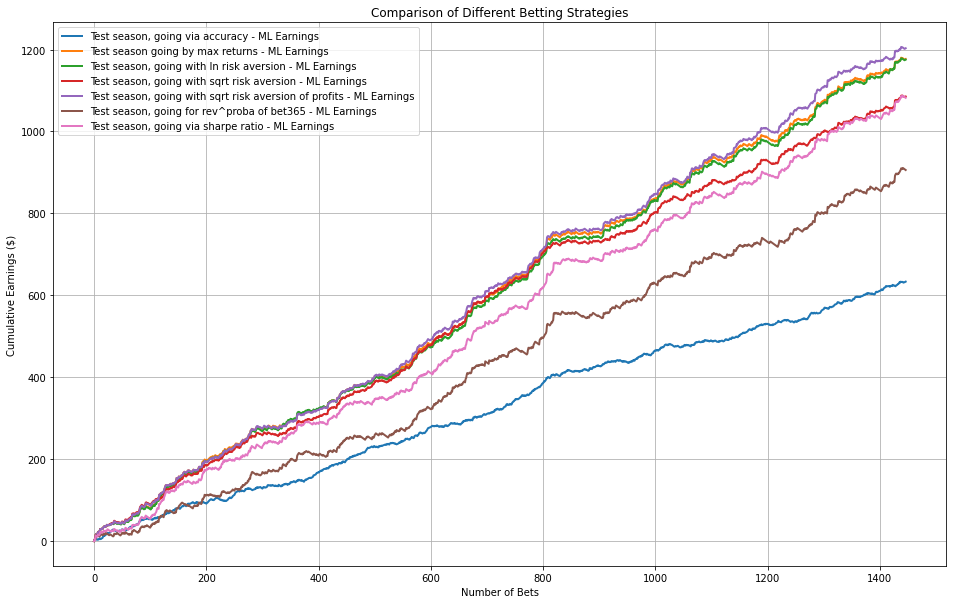

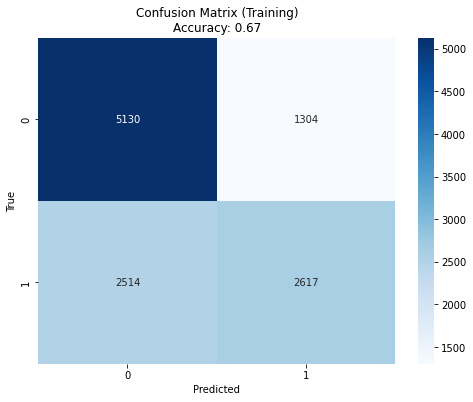

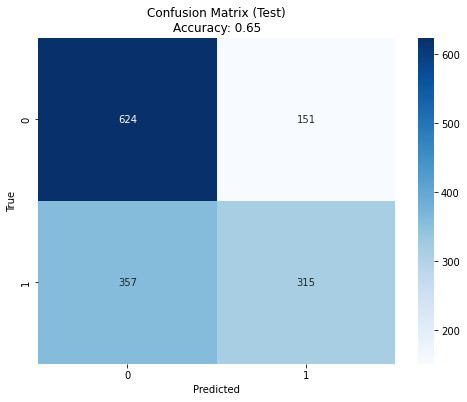

Training OvR AUC: 0.72519137545636
Test OvR AUC: 0.699431643625192


<ipython-input-156-45913fffdac3>:134: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_mismatch_gaps, shade=True, color='blue', label='Mismatched')
<ipython-input-156-45913fffdac3>:135: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_match_gaps, shade=True, color='green', label='Matched')
<ipython-input-156-45913fffdac3>:142: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_mismatch_gaps, shade=True, color='red', label='Mismatched')
<ipython-input-156-45913fffdac3>:143: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update 

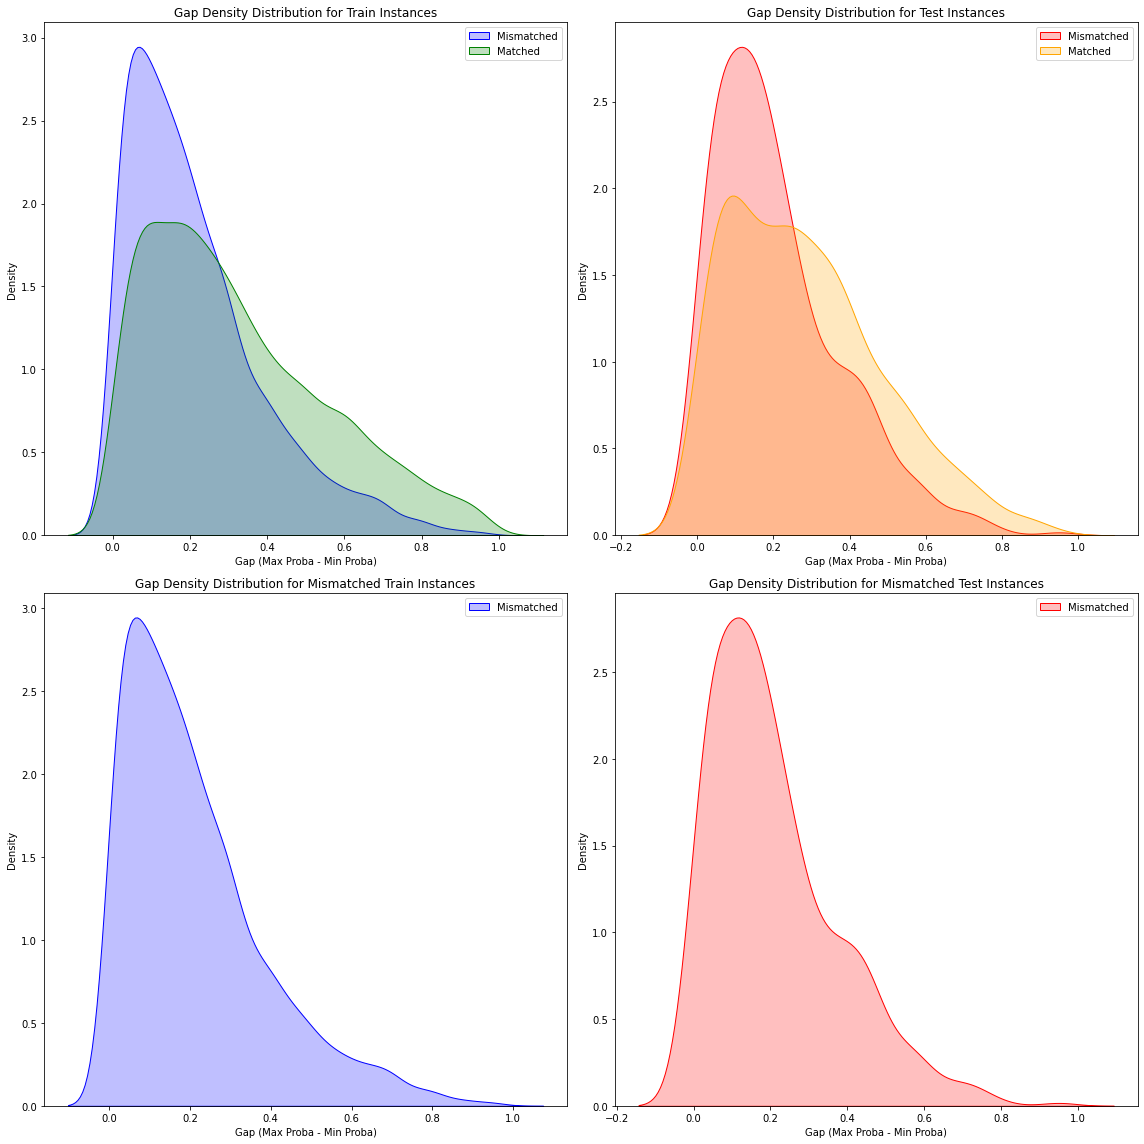

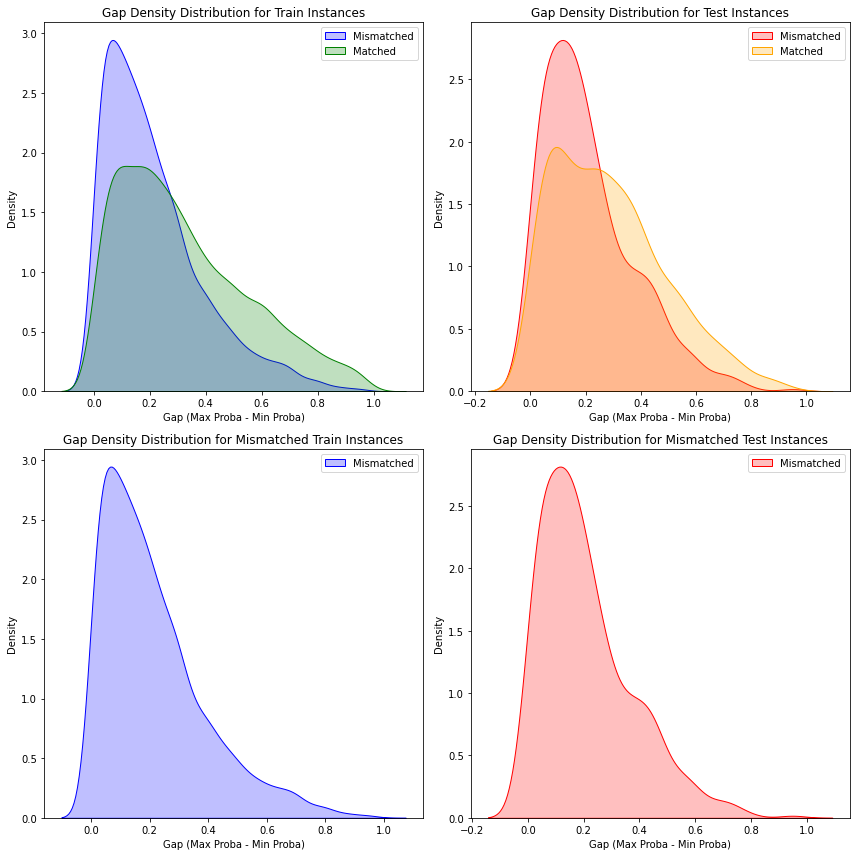

"\nbest hyper parameters for home regression: {'max_depth': 1, 'n_estimators': 100, 'objective': 'count:poisson', 'subsample': 0.5}\nbest parameters for away reg: {'max_depth': 1, 'n_estimators': 50, 'objective': 'count:poisson', 'subsample': 0.5}\n"

In [156]:

print("best hyper parameters for home regression:", home_reg.best_params_)
print("best parameters for away reg:", away_reg.best_params_)

home_train = home_reg.predict(train_scaled)
away_train = away_reg.predict(train_scaled)

# plot_by_matchweek(ytrain_home, home_train, train['Matchweek'], 'MSE By machweek for home regression')
# plot_by_matchweek(ytrain_away, away_train, train['Matchweek'], 'MSE By machweek for away regression')

home_test = home_reg.predict(test_scaled)
away_test = away_reg.predict(test_scaled)

# plot_by_matchweek(ytest_home, home_test, test['Matchweek'], 'MSE By machweek for home regression')
# plot_by_matchweek(ytest_away, away_test, test['Matchweek'], 'MSE By machweek for away regression')

print('train home rmse:', np.sqrt(mean_squared_error(ytrain_home, home_train)))
print('train away rmse:', np.sqrt(mean_squared_error(ytrain_away, away_train)))

print('test home rmse:', np.sqrt(mean_squared_error(ytest_home, home_test)))
print('test away rmse:', np.sqrt(mean_squared_error(ytest_away, away_test)))

train_probas = extract_poisson_probas_binary(home_train, away_train)
test_probas = extract_poisson_probas_binary(home_test, away_test)

sharpe_ratios = np.asarray(test_probas*(betting_data_test**2 - test_probas*(betting_data_test**2) + 2*test_probas*betting_data_test - 1))
print(sharpe_ratios.shape)
# bet_and_plot_thresh(test_probas, y_test, betting_data, normalized_probas, extra_title=' Test season, going via accuracy')
# bet_and_plot_thresh(np.asarray(betting_data)*test_probas, y_test, betting_data, normalized_probas, extra_title=' Test season going by max returns', threshold =1)
# bet_and_plot_thresh(test_probas*np.log(np.asarray(betting_data)), y_test, betting_data, normalized_probas, extra_title=' Test season, going with ln risk aversion', threshold=0)
# bet_and_plot_thresh(test_probas*np.sqrt(np.asarray(betting_data)), y_test, betting_data, normalized_probas, extra_title=' Test season, going with sqrt risk aversion', threshold=0)
# bet_and_plot_thresh(test_probas*np.sqrt(np.asarray(betting_data)-1), y_test, betting_data, normalized_probas, extra_title=' Test season, going with sqrt risk aversion', threshold=0)

# bet_and_plot_thresh(np.power(np.asarray(betting_data),normalized_probas), y_test, betting_data, normalized_probas, extra_title=' Test season, going for rev^proba of bet365', threshold=1)
# bet_and_plot_thresh(sharpe_ratios, y_test, betting_data, normalized_probas, extra_title=' Test season, going via sharpe ratio')

strategies = []

strategies.append(bet_thresh(test_probas, y_test, betting_data_test, normalized_probas, extra_title='Test season, going via accuracy'))
strategies.append(bet_thresh(np.asarray(betting_data_test)*test_probas, y_test, betting_data_test, normalized_probas, extra_title='Test season going by max returns', threshold=1))
strategies.append(bet_thresh(test_probas*np.log(np.asarray(betting_data_test)), y_test, betting_data_test, normalized_probas, extra_title='Test season, going with ln risk aversion', threshold=0))
strategies.append(bet_thresh(test_probas*np.sqrt(np.asarray(betting_data_test)), y_test, betting_data_test, normalized_probas, extra_title='Test season, going with sqrt risk aversion', threshold=0))
strategies.append(bet_thresh(test_probas*np.sqrt(np.asarray(betting_data_test)-1), y_test, betting_data_test, normalized_probas, extra_title='Test season, going with sqrt risk aversion of profits', threshold=0))

strategies.append(bet_thresh(np.power(np.asarray(betting_data_test),normalized_probas), y_test, betting_data_test, normalized_probas, extra_title='Test season, going for rev^proba of bet365', threshold=1))
strategies.append(bet_thresh(sharpe_ratios, y_test, betting_data_test, normalized_probas, extra_title='Test season, going via sharpe ratio'))
plt.figure(figsize=(16, 10))

for cum_earnings, cum_bo_earnings, cum_delta_earnings, title in strategies:
    print('for '+title+' strategy, we earn: ',cum_earnings[-1])
    plt.plot(cum_earnings, label=f'{title} - ML Earnings', linestyle='-', linewidth=2)
    #plt.plot(cum_bo_earnings, label=f'{title} - Betting Odds Earnings', linestyle='--', linewidth=2)
    #plt.plot(cum_delta_earnings, label=f'{title} - Delta Earnings', linestyle=':', linewidth=2)

plt.xlabel('Number of Bets')
plt.ylabel('Cumulative Earnings ($)')
plt.title('Comparison of Different Betting Strategies')
plt.legend(loc='best')
plt.grid(True)
plt.show()

train_classes = np.argmax(train_probas, axis=1)
train_classes = train_classes

# Create a confusion matrix
conf_matrix = confusion_matrix(y_train, train_classes)

# Calculate accuracy
accuracy = accuracy_score(y_train, train_classes)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Training)\nAccuracy: {accuracy:.2f}')
plt.show()

test_classes = np.argmax(test_probas, axis=1)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, test_classes)

# Calculate accuracy
accuracy = accuracy_score(y_test, test_classes)


# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Test)\nAccuracy: {accuracy:.2f}')
plt.show()
train_auc_ovr = roc_auc_score(y_train, train_probas[:,1])
print(f"Training OvR AUC: {train_auc_ovr}")

# Calculate OvO AUC for the test set
test_auc_ovr = roc_auc_score(y_test, test_probas[:,1])
print(f"Test OvR AUC: {test_auc_ovr}")

train_bets = np.asarray(train[['B365A','B365D', 'B365A']])
# Calculate the max and min probabilities
train_max_proba = np.max(train_probas, axis=1)
train_min_proba = np.sort(train_probas, axis=1)[:, ::-1][:,1]
test_max_proba = np.max(test_probas, axis=1)
test_min_proba = np.sort(test_probas, axis=1)[:, ::-1][:,1]

# Calculate the gaps
train_gaps = train_max_proba - train_min_proba
test_gaps = test_max_proba - test_min_proba

# Get predicted labels
train_preds = np.argmax(train_probas, axis=1)
test_preds = np.argmax(test_probas, axis=1)

# Identify mismatches
train_mismatches = train_preds != y_train
test_mismatches = test_preds != y_test

# Identify matches
train_matches = train_preds == y_train
test_matches = test_preds == y_test

# Filter gaps for mismatched and matched instances
train_mismatch_gaps = train_gaps[train_mismatches]
test_mismatch_gaps = test_gaps[test_mismatches]
train_match_gaps = train_gaps[train_matches]
test_match_gaps = test_gaps[test_matches]

# Plot the density distributions
plt.figure(figsize=(16, 16))

plt.subplot(2, 2, 1)
sns.kdeplot(train_mismatch_gaps, shade=True, color='blue', label='Mismatched')
sns.kdeplot(train_match_gaps, shade=True, color='green', label='Matched')
plt.xlabel('Gap (Max Proba - Min Proba)')
plt.ylabel('Density')
plt.title('Gap Density Distribution for Train Instances')
plt.legend()

plt.subplot(2, 2, 2)
sns.kdeplot(test_mismatch_gaps, shade=True, color='red', label='Mismatched')
sns.kdeplot(test_match_gaps, shade=True, color='orange', label='Matched')
plt.xlabel('Gap (Max Proba - Min Proba)')
plt.ylabel('Density')
plt.title('Gap Density Distribution for Test Instances')
plt.legend()

plt.subplot(2, 2, 3)
sns.kdeplot(train_mismatch_gaps, shade=True, color='blue', label='Mismatched')
plt.xlabel('Gap (Max Proba - Min Proba)')
plt.ylabel('Density')
plt.title('Gap Density Distribution for Mismatched Train Instances')
plt.legend()

plt.subplot(2, 2, 4)
sns.kdeplot(test_mismatch_gaps, shade=True, color='red', label='Mismatched')
plt.xlabel('Gap (Max Proba - Min Proba)')
plt.ylabel('Density')
plt.title('Gap Density Distribution for Mismatched Test Instances')
plt.legend()

plt.tight_layout()
plt.show()

train_bets = np.asarray(train[['B365A','B365D', 'B365A']])
# Calculate the max and min probabilities
train_max_proba = np.max(train_probas, axis=1)
train_min_proba = np.sort(train_probas, axis=1)[:, ::-1][:,1]
test_max_proba = np.max(test_probas, axis=1)
test_min_proba = np.sort(test_probas, axis=1)[:, ::-1][:,1]


# Calculate the gaps
train_gaps = train_max_proba - train_min_proba
test_gaps = test_max_proba - test_min_proba

# Get predicted labels
train_preds = np.argmax(train_probas, axis=1)
test_preds = np.argmax(test_probas, axis=1)

# Identify mismatches
train_mismatches = train_preds != y_train
test_mismatches = test_preds != y_test

# Identify matches
train_matches = train_preds == y_train
test_matches = test_preds == y_test

# Filter gaps for mismatched and matched instances
train_mismatch_gaps = train_gaps[train_mismatches]
test_mismatch_gaps = test_gaps[test_mismatches]
train_match_gaps = train_gaps[train_matches]
test_match_gaps = test_gaps[test_matches]

# Plot the density distributions
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
sns.kdeplot(train_mismatch_gaps, fill=True, color='blue', label='Mismatched')
sns.kdeplot(train_match_gaps, fill=True, color='green', label='Matched')
plt.xlabel('Gap (Max Proba - Min Proba)')
plt.ylabel('Density')
plt.title('Gap Density Distribution for Train Instances')
plt.legend()

plt.subplot(2, 2, 2)
sns.kdeplot(test_mismatch_gaps, fill=True, color='red', label='Mismatched')
sns.kdeplot(test_match_gaps, fill=True, color='orange', label='Matched')
plt.xlabel('Gap (Max Proba - Min Proba)')
plt.ylabel('Density')
plt.title('Gap Density Distribution for Test Instances')
plt.legend()

plt.subplot(2, 2, 3)
sns.kdeplot(train_mismatch_gaps, fill=True, color='blue', label='Mismatched')
plt.xlabel('Gap (Max Proba - Min Proba)')
plt.ylabel('Density')
plt.title('Gap Density Distribution for Mismatched Train Instances')
plt.legend()

plt.subplot(2, 2, 4)
sns.kdeplot(test_mismatch_gaps, fill=True, color='red', label='Mismatched')
plt.xlabel('Gap (Max Proba - Min Proba)')
plt.ylabel('Density')
plt.title('Gap Density Distribution for Mismatched Test Instances')
plt.legend()

plt.tight_layout()
plt.show()
'''
best hyper parameters for home regression: {'max_depth': 1, 'n_estimators': 100, 'objective': 'count:poisson', 'subsample': 0.5}
best parameters for away reg: {'max_depth': 1, 'n_estimators': 50, 'objective': 'count:poisson', 'subsample': 0.5}
'''

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
home_reg = GridSearchCV(KNeighborsRegressor(max_iter=1000),
                        param_grid={'n_neighbors' : [i for i in range(5, 200, 5)]},
                        scoring='neg_mean_squared_error', cv=3, verbose=3)

away_reg = GridSearchCV(KNeighborsRegressor(max_iter=1000),
                        param_grid={'n_neighbors' : [i for i in range(5, 200, 5)]},
                        scoring='neg_mean_squared_error', cv=3, verbose=3)


home_reg.fit(train_scaled, ytrain_home)
away_reg.fit(train_scaled, ytrain_away)
'''
best hyper parameters for home regression: {'criterion': 'poisson', 'max_depth': 5, 'max_features': 0.3, 'max_samples': 0.5}
best parameters for away reg: {'criterion': 'poisson', 'max_depth': 5, 'max_features': 0.3, 'max_samples': 0.25}
'''

print("best hyper parameters for home regression:", home_reg.best_params_)
print("best parameters for away reg:", away_reg.best_params_)
home_train = home_reg.predict(train_scaled)
away_train = away_reg.predict(train_scaled)

home_test = home_reg.predict(test_scaled)
away_test = away_reg.predict(test_scaled)
print('train home rmse:', np.sqrt(mean_squared_error(ytrain_home, home_train)))
print('train away rmse:', np.sqrt(mean_squared_error(ytrain_away, away_train)))

print('test home rmse:', np.sqrt(mean_squared_error(ytest_home, home_test)))
print('test away rmse:', np.sqrt(mean_squared_error(ytest_away, away_test)))


In [159]:
# # # ## Save the model

# home_reg.best_estimator_.save_model("XGBHome.json")
# away_reg.best_estimator_.save_model("XGBAway.json")

AttributeError: 'PoissonRegressor' object has no attribute 'save_model'